## Import Libraries and Layers

In [4]:
from IPython.display import display
import arcgis
from arcgis.gis import GIS
import pandas as pd
pd.set_option('display.max_columns', 500)
from arcgis.features import FeatureLayer
from arcgis.mapping import WebMap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
gis = GIS("https://datascienceqa.esri.com/portal", "portaladmin", "esri.agp", verify_cert=False)
# gis = GIS("https://datascienceqa.esri.com/portal", "portaladmin", "esri.agp")

In [13]:
# Layers Used
# Provider data layer
provider_layer = FeatureLayer("https://datascienceqa.esri.com/server/rest/services/Hosted/provider_clean_data_geocoded_6_19/FeatureServer/0")

# Population Density
from arcgis.mapping import MapImageLayer
popdensity = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Median Income
medIncome = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/3e5f8ebe5a114a61b7f350e7a1203761/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Median Age
medAge = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/e2558ac0c5e04235ad7820773e89d110/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Health Insurance Coverage
tx_insurance_state = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer")
tx_insurance_county = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer/1")
tx_insurance_tract = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer/2")

# Fertility layers for State, County and Tract (Percent of women 15 to 50 who had a birth in the past 12 months)
fertility_state = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/0")
fertility_county = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/1")
fertility_tract = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/2")

AttributeError: 'MapImageLayer' object has no attribute '_lazy_properties'

In [7]:
search_result = gis.content.search('title: provider_data_geocoded_7_30','Feature Layer')
provider_data_item = search_result[0]
provider_data_item

<Item title:"provider_data_geocoded_7_30" type:Feature Layer Collection owner:portaladmin>

In [8]:
provider_data_layer = provider_data_item.layers[0]
provider_data_layer

<FeatureLayer url:"https://datascienceqa.esri.com/server/rest/services/Hosted/provider_data_geocoded_7_30/FeatureServer/0">

## OBGYN Providers and Other Data

#### Create df for OBGYN providers

In [9]:
# Get provider data for obgyn providers only

obgyn_featureset = provider_data_layer.query(where="user_taxonomy_code_1 in ('207V00000X','207VC0200X','207VF0040X','207VX0201X','207VG0400X','207VH0002X','207VM0101X','207VB0002X','207VX0000X','207VE0102X','363LX0001X','163WR1000X','163WW0101X','282NW0100X')", out_fields='x,y,user_npi,user_entity_type,user_provider_gender,user_taxonomy_code_1,user_full_address,postal,city,subregion,region,regionabbr')
obgyn_df = obgyn_featureset.sdf
obgyn_df.head()

,SHAPE,city,objectid,postal,region,regionabbr,subregion,user_entity_type,user_full_address,user_npi,user_provider_gender,user_taxonomy_code_1,x,y
0,"{""x"": -97.49116252599998, ""y"": 35.261905469000...",Norman,8,73072,Oklahoma,OK,Cleveland County,Individual,"3400 W TECUMSEH RD, SUITE 205, NORMAN, OK 7307...",1.487658e+09,F,207V00000X,-97.491163,35.261905
1,"{""x"": -120.00990533799995, ""y"": 46.31641132900...",Sunnyside,24,98944,Washington,WA,Yakima County,Individual,"803 E LINCOLN AVE, , SUNNYSIDE, WA 989442383",1.265435e+09,F,207V00000X,-120.009905,46.316411
2,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Charleston,26,25302,West Virginia,WV,Kanawha County,Individual,"830 PENNSYLVANIA AVE, SUITE 108, CHARLESTON, W...",1.447253e+09,M,207V00000X,-81.637393,38.359803
3,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Charleston,99,25302,West Virginia,WV,Kanawha County,Individual,"830 PENNSYLVANIA AVE, STE 402, CHARLESTON, WV ...",1.487658e+09,M,207V00000X,-81.637393,38.359803
4,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Charleston,172,25302,West Virginia,WV,Kanawha County,Individual,"830 PENNSYLVANIA AVE, STE 402, CHARLESTON, WV ...",1.255334e+09,M,207V00000X,-81.637393,38.359803


In [10]:
obgyn_df.shape

(67638, 14)

In [10]:
# Create csv of data
obgyn_df.to_csv('obgyn_df.csv', index=None, header=True)

In [11]:
obgyn_county_df = obgyn_df[['regionabbr','subregion']]
obgyn_county_df['Provider_Count'] = obgyn_county_df.groupby(['regionabbr','subregion'])['subregion'].transform('count')
obgyn_count_df = obgyn_county_df.drop_duplicates(subset='subregion', keep="first", inplace=True)
obgyn_county_df.shape

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(1282, 3)

In [12]:
obgyn_county_df = obgyn_county_df.sort_values(by=['Provider_Count'], ascending=False)
obgyn_county_df.head()

,regionabbr,subregion,Provider_Count
100,CA,Los Angeles County,2094
37,IL,Cook County,1586
1167,NY,New York County,1136
9,TX,Harris County,1124
134,AZ,Maricopa County,844


In [13]:
# Check missing
obgyn_county_df.isnull().sum()

regionabbr        0
subregion         0
Provider_Count    0
dtype: int64

#### Create County df from Demographics Data

In [14]:
# Search for Population data layer
popsearch_result = gis.content.search('title: 2018 USA Population Density')
popsearch_result

[<Item title:"2018 USA Tapestry Segmentation" type:Map Image Layer owner:esri_livingatlas>,
 <Item title:"2018 USA Population Density" type:Map Image Layer owner:esri_livingatlas>]

<Item title:"2018 USA Population Density" type:Map Image Layer owner:esri_livingatlas>
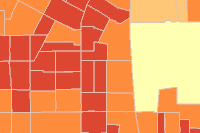

In [15]:
# Get Population Density
popdensity = popsearch_result[1]
popdensity

In [17]:
# Check all layers in population Density
popdensity.layers

[<FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/0">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/1">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/2">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/3">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/4">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographi

In [19]:
# county_layer = FeatureLayer("https://datascienceqa.esri.com/portal/sharing/servers/3e5f8ebe5a114a61b7f350e7a1203761/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/46")
county_layer = popdensity.layers[46]
county_df = pd.DataFrame()
offset = 0
while offset <= 3000:
    county_featureset_test = county_layer.query(return_all_records=False,
                                           result_offset=offset,
                                           result_record_count=750)
    county_df_test = county_featureset_test.sdf
    county_df = pd.concat([county_df_test, county_df], ignore_index=True)
    offset += 750

In [20]:
county_df.shape

(3142, 1943)

In [38]:
# Create csv of data
county_df.to_csv('county_df.csv', index=None, header=True)

In [22]:
for field in county_layer.properties.fields:
#     print(field)
    print(field['name'], '\t', field['alias'])
#     print(field[0])

OBJECTID 	 OBJECTID
Shape 	 Shape
ID 	 ID
NAME 	 NAME
STATE_NAME 	 STATE_NAME
ST_ABBREV 	 ST_ABBREV
AREA 	 Area in Square Miles (Calculated)
TOTPOP_CY 	 2018 Total Population (Esri)
HHPOP_CY 	 2018 Household Population (Esri)
FAMPOP_CY 	 2018 Family Population (Esri)
GQPOP_CY 	 2018 Group Quarters Population (Esri)
POPDENS_CY 	 2018 Population Density (Pop per Square Mile) (Esri)
TOTHH_CY 	 2018 Total Households (Esri)
AVGHHSZ_CY 	 2018 Average Household Size (Esri)
FAMHH_CY 	 2018 Total Family Households (Esri)
AVGFMSZ_CY 	 2018 Average Family Size (Esri)
TOTHU_CY 	 2018 Total Housing Units (Esri)
OWNER_CY 	 2018 Owner Occupied Housing Units (Esri)
RENTER_CY 	 2018 Renter Occupied Housing Units (Esri)
VACANT_CY 	 2018 Vacant Housing Units (Esri)
POPGRW10CY 	 2010-2018 Population: Annual Growth Rate (Esri)
HHGRW10CY 	 2010-2018 Households: Annual Growth Rate (Esri)
FAMGRW10CY 	 2010-2018 Families: Annual Growth Rate (Esri)
GENALPHACY 	 2018 Generation Alpha Population (Born 2017 or Lat

FAGE38_FY 	 2023 Female Population Age 38 (Esri)
FAGE39_FY 	 2023 Female Population Age 39 (Esri)
FAGE40_FY 	 2023 Female Population Age 40 (Esri)
FAGE41_FY 	 2023 Female Population Age 41 (Esri)
FAGE42_FY 	 2023 Female Population Age 42 (Esri)
FAGE43_FY 	 2023 Female Population Age 43 (Esri)
FAGE44_FY 	 2023 Female Population Age 44 (Esri)
FAGE45_FY 	 2023 Female Population Age 45 (Esri)
FAGE46_FY 	 2023 Female Population Age 46 (Esri)
FAGE47_FY 	 2023 Female Population Age 47 (Esri)
FAGE48_FY 	 2023 Female Population Age 48 (Esri)
FAGE49_FY 	 2023 Female Population Age 49 (Esri)
FAGE50_FY 	 2023 Female Population Age 50 (Esri)
FAGE51_FY 	 2023 Female Population Age 51 (Esri)
FAGE52_FY 	 2023 Female Population Age 52 (Esri)
FAGE53_FY 	 2023 Female Population Age 53 (Esri)
FAGE54_FY 	 2023 Female Population Age 54 (Esri)
FAGE55_FY 	 2023 Female Population Age 55 (Esri)
FAGE56_FY 	 2023 Female Population Age 56 (Esri)
FAGE57_FY 	 2023 Female Population Age 57 (Esri)
FAGE58_FY 	 2023 Fem

In [147]:
# Keeping specific columns
county_df_new = county_df[['ST_ABBREV','NAME','ASIAN_CY','AMERIND_CY','AVGHHSZ_CY','AVGHINC_CY','BLACK_CY','EDUCBASECY','HISPPOP_CY',
                          'MEDAGE_CY','MINORITYCY','OTHRACE_CY','PCI_CY','POPDENS_CY','UNEMPRT_CY','WHITE_CY','SMCOLL_CY',
                          'ASSCDEG_CY','BACHDEG_CY','GRADDEG_CY']]
county_df_new.head()

,ST_ABBREV,NAME,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY
0,WV,Doddridge County,33,26,2.42,51537,201,6405,91,43.2,467,5,20870,27.7,5.8,8454,1048,363,695,368
1,WV,Fayette County,101,112,2.37,50170,2000,33677,540,44.7,3456,106,20953,69.2,4.7,42649,5473,2901,3215,1731
2,WV,Gilmer County,51,53,2.35,50297,1044,6106,479,39.0,1720,209,20296,24.5,7.6,6772,1272,336,632,460
3,WV,Grant County,26,19,2.40,52611,118,9296,171,46.9,453,82,21869,26.2,3.8,12092,1270,731,804,655
4,WV,Greenbrier County,196,137,2.27,55885,1078,27410,590,46.8,2669,184,24505,36.0,1.0,34375,4667,1810,3689,2274


#### Remove Unnecessary columns

In [23]:
# Removing columns for 2023,2010,2000
county_df = county_df.loc[:,~county_df.columns.str.contains('FY|10|00')]
len(county_df.columns)

894

In [24]:
# Removing columns for individual age
county_df = county_df.loc[:,~county_df.columns.str.startswith(('AGE','MAGE','FAGE'))]
len(county_df.columns)

640

In [25]:
# Removing columns for Industry, Occupation
county_df = county_df.loc[:,~county_df.columns.str.startswith(('IND','OCC'))]
len(county_df.columns)

596

In [26]:
# Removing Individual Income Columns
county_df = county_df.loc[:,~county_df.columns.str.contains('A15|A25|A35|A45|A55|A65|A75')]
len(county_df.columns)

366

In [27]:
# Removing columns for Disposable Income and Net Worth
county_df = county_df.loc[:,~county_df.columns.str.startswith(('DI','NW'))]
len(county_df.columns)

348

In [28]:
# Removing columns for Tapestry Segmentation
county_df = county_df.loc[:,~county_df.columns.str.startswith(('TSE','THH','TADULT'))]
len(county_df.columns)

190

In [29]:
# Removing columns for Home Value
county_df = county_df.loc[:,~county_df.columns.str.startswith(('VAL'))]
len(county_df.columns)

181

In [30]:
county_df.columns

Index(['AAGEBASECY', 'AGGDI_CY', 'AGGHINC_CY', 'AGGINC_CY', 'AGGNW_CY',
       'AIFBASE_CY', 'AIMBASE_CY', 'AMERIND_CY', 'AREA', 'ASIAN_CY',
       ...
       'TOTHU_CY', 'TOTPOP_CY', 'UNEMPRT_CY', 'UNEMP_CY', 'VACANT_CY',
       'WAGEBASECY', 'WHITE_CY', 'WHTFBASECY', 'WHTMBASECY', 'WIDOWED_CY'],
      dtype='object', length=181)

In [31]:
print(obgyn_county_df.shape)
print(county_df.shape)

(1282, 3)
(3142, 181)


#### Create County df from Expenditure Data

In [26]:
# Search for Population data layer
expsearch_result = gis.content.search('title: 2018 USA Health Insurance Spending')
expsearch_result

[<Item title:"2018 USA High Credit Card Expenditures" type:Map Image Layer owner:esri_livingatlas>,
 <Item title:"2018 USA Health Insurance Spending" type:Map Image Layer owner:esri_livingatlas>]

<Item title:"2018 USA Health Insurance Spending" type:Map Image Layer owner:esri_livingatlas>
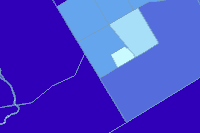

In [27]:
# Get Healthcare expenditure data
health_exp = expsearch_result[1]
health_exp

In [28]:
# Check all layers in population Density
health_exp.layers

[<FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/3fe029d089124e5dab518fd2c4f7eabe/rest/services/USA_Consumer_Expenditures_2018/MapServer/0">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/3fe029d089124e5dab518fd2c4f7eabe/rest/services/USA_Consumer_Expenditures_2018/MapServer/1">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/3fe029d089124e5dab518fd2c4f7eabe/rest/services/USA_Consumer_Expenditures_2018/MapServer/2">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/3fe029d089124e5dab518fd2c4f7eabe/rest/services/USA_Consumer_Expenditures_2018/MapServer/3">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/3fe029d089124e5dab518fd2c4f7eabe/rest/services/USA_Consumer_Expenditures_2018/MapServer/4">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/3fe029d089124e5dab518fd2c4f7eabe/rest/services/USA_Consumer_Expenditures_2018/MapServer/5">

In [30]:
# Look at the fields and their data types
health_exp_county_layer = health_exp.layers[46]
for f in health_exp_county_layer.properties.fields:
    print(f['name'],'      ',f['alias'])

OBJECTID        OBJECTID
Shape        Shape
ID        ID
NAME        NAME
STATE_NAME        STATE_NAME
ST_ABBREV        ST_ABBREV
AREA        Area in Square Miles (Calculated)
X2001_X        2018 Alcoholic Beverages
X2001_A        2018 Alcoholic Beverages: Average
X2001_I        2018 Alcoholic Beverages: Index
X2002_X        2018 Alcoholic Beverages at Home
X2002_A        2018 Alcoholic Beverages at Home: Average
X2002_I        2018 Alcoholic Beverages at Home: Index
X2003_X        2018 Alcoholic Beverages at Home - Beer & Ale
X2003_A        2018 Alcoholic Beverages at Home - Beer & Ale: Average
X2003_I        2018 Alcoholic Beverages at Home - Beer & Ale: Index
X2004_X        2018 Alcoholic Beverages at Home - Whiskey
X2004_A        2018 Alcoholic Beverages at Home - Whiskey: Average
X2004_I        2018 Alcoholic Beverages at Home - Whiskey: Index
X2005_X        2018 Alcoholic Beverages at Home - Wine
X2005_A        2018 Alcoholic Beverages at Home - Wine: Average
X2005_I        2018 

X1129_A        2018 Food at Home - Bottled Water: Average
X1129_I        2018 Food at Home - Bottled Water: Index
X1090_X        2018 Food at Home - Snacks/Other Food
X1090_A        2018 Food at Home - Snacks/Other Food: Average
X1090_I        2018 Food at Home - Snacks/Other Food: Index
X1091_X        2018 Food at Home - Sugar & Other Sweets
X1091_A        2018 Food at Home - Sugar & Other Sweets: Average
X1091_I        2018 Food at Home - Sugar & Other Sweets: Index
X1092_X        2018 Food at Home - Candy & Chewing Gum
X1092_A        2018 Food at Home - Candy & Chewing Gum: Average
X1092_I        2018 Food at Home - Candy & Chewing Gum: Index
X1093_X        2018 Food at Home - Sugar
X1093_A        2018 Food at Home - Sugar: Average
X1093_I        2018 Food at Home - Sugar: Index
X1094_X        2018 Food at Home - Artificial Sweeteners
X1094_A        2018 Food at Home - Artificial Sweeteners: Average
X1094_I        2018 Food at Home - Artificial Sweeteners: Index
X1095_X        2018 

X6052_I        2018 Driver`s License Fees: Index
X6053_X        2018 Vehicle Inspection Fees
X6053_A        2018 Vehicle Inspection Fees: Average
X6053_I        2018 Vehicle Inspection Fees: Index
X6054_X        2018 Parking Fees & Tolls excluding Trips
X6054_A        2018 Parking Fees & Tolls excluding Trips: Average
X6054_I        2018 Parking Fees & Tolls excluding Trips: Index
X6055_X        2018 Parking Fees excluding Residence (Not on Trips)
X6055_A        2018 Parking Fees excluding Residence (Not on Trips): Average
X6055_I        2018 Parking Fees excluding Residence (Not on Trips): Index
X6056_X        2018 Tolls/Electronic Toll Passes excluding Trips
X6056_A        2018 Tolls/Electronic Toll Passes excluding Trips: Average
X6056_I        2018 Tolls/Electronic Toll Passes excluding Trips: Index
X6057_X        2018 Towing Charges
X6057_A        2018 Towing Charges: Average
X6057_I        2018 Towing Charges: Index
X6068_X        2018 Auto Service Clubs & GPS Services
X6068_A   

In [36]:
# county_layer = FeatureLayer("https://datascienceqa.esri.com/portal/sharing/servers/3e5f8ebe5a114a61b7f350e7a1203761/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/46")
health_exp_county_layer = health_exp.layers[46]
# health_exp_county_featureset = health_exp_county_layer.query(outfields='X8001_A,X8002_A,X8013_A')
# health_exp_county_df = health_exp_county_featureset.sdf
# health_exp_county_df.head()

health_exp_county_df = pd.DataFrame()
offset = 0
while offset <= 3000:
    health_exp_county_featureset = health_exp_county_layer.query(return_all_records=False,result_offset=offset,result_record_count=150)
    county_df_test = health_exp_county_featureset.sdf
    health_exp_county_df = pd.concat([county_df_test, health_exp_county_df], ignore_index=True)
    offset += 150

In [37]:
health_exp_county_df.shape

(3142, 2180)

In [39]:
health_exp_county_df.to_csv('health_exp_county_df.csv', index=None, header=True)

In [44]:
# Keeping specific columns
health_exp_new = health_exp_county_df[['ST_ABBREV','NAME','X8001_A','X8002_A','X8013_A','X8018_A','X8019_A','X8024_A','X8032_A','X13002_A','X13004_A']]
health_exp_new.head()

,ST_ABBREV,NAME,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,WV,Doddridge County,4466.09,2894.59,632.30,1571.51,794.24,52.65,132.74,270.40,4548.75
1,WV,Fayette County,4258.47,2763.71,592.84,1494.76,759.18,49.59,124.51,257.88,4436.31
2,WV,Gilmer County,4182.28,2716.19,579.07,1466.09,745.24,47.76,122.37,248.70,4427.67
3,WV,Grant County,4382.40,2848.84,596.32,1533.57,784.03,50.31,125.52,272.29,4723.08
4,WV,Greenbrier County,4548.73,2959.83,618.61,1588.90,816.44,50.80,130.12,280.79,4990.78


#### Merge dataframes

In [148]:
# Merge provider count and demographic data at county level
obgyn_demo_df = pd.merge(obgyn_county_df,county_df_new,left_on=['regionabbr','subregion'], right_on=['ST_ABBREV','NAME'],how='left')

# Merge provider count and women_df at state level
newcounty_obgyn_df = pd.merge(obgyn_demo_df,health_exp_new,left_on=['regionabbr','subregion'], right_on=['ST_ABBREV','NAME'],how='left')

In [149]:
newcounty_obgyn_df.shape

(1282, 34)

In [150]:
# Drop duplicate columns
newcounty_obgyn_df.drop(['ST_ABBREV_x','NAME_x','ST_ABBREV_y','NAME_y'], axis=1, inplace=True)

In [151]:
newcounty_obgyn_df.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,CA,Los Angeles County,2094,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,IL,Cook County,1586,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,NY,New York County,1136,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,TX,Harris County,1124,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,AZ,Maricopa County,844,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


In [152]:
newcounty_obgyn_df.to_csv('newcounty_obgyn_df.csv',index=None,header=True)

In [21]:
# Read from csv
newcounty_obgyn_df = pd.read_csv('newcounty_obgyn_df.csv')
newcounty_obgyn_df.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,CA,Los Angeles County,2094,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,IL,Cook County,1586,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,NY,New York County,1136,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,TX,Harris County,1124,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,AZ,Maricopa County,844,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


In [22]:
test_newcounty_df = newcounty_obgyn_df.copy()
test_newcounty_df.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,CA,Los Angeles County,2094,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,IL,Cook County,1586,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,NY,New York County,1136,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,TX,Harris County,1124,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,AZ,Maricopa County,844,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


In [35]:
# test_newcounty_df.drop(['OBJECTID','SHAPE','STATE_NAME','ST_ABBREV','NAME','Shape_Area','Shape_Length','TLIFENAME','ID','TLIFECODE'], axis=1, inplace=True)
# test_newcounty_df.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,CA,Los Angeles County,2094,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,IL,Cook County,1586,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187.0,250519.0,132865.0,186804.0,169815.0,238778.0,329118.0,243670.0,2007274.0,15131.0,4083.0,22733.0,66348.

In [334]:
# Change Provider Count to Float
# test_newcounty_df['Provider_Count'] = test_newstate_df['Provider_Count'].astype(float)

#### Handle Missing Values

In [23]:
# Any missing values in the data
test_newcounty_df.isnull().sum().sum()

3348

In [24]:
# Columns with missing values
test_newcounty_df.isnull().sum()

regionabbr          0
subregion           0
Provider_Count      0
ASIAN_CY          124
AMERIND_CY        124
AVGHHSZ_CY        124
AVGHINC_CY        124
BLACK_CY          124
EDUCBASECY        124
HISPPOP_CY        124
MEDAGE_CY         124
MINORITYCY        124
OTHRACE_CY        124
PCI_CY            124
POPDENS_CY        124
UNEMPRT_CY        124
WHITE_CY          124
SMCOLL_CY         124
ASSCDEG_CY        124
BACHDEG_CY        124
GRADDEG_CY        124
X8001_A           124
X8002_A           124
X8013_A           124
X8018_A           124
X8019_A           124
X8024_A           124
X8032_A           124
X13002_A          124
X13004_A          124
dtype: int64

In [25]:
# Dataframe of rows and columns with null
null_data = test_newcounty_df[test_newcounty_df.isnull().any(axis=1)]
null_data.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
29,CA,City and County of San Francisco,330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,CA,Sacramento,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,MD,City of Baltimore,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,HI,City and County of Honolulu,286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,CO,City and County of Denver,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
null_data.shape

(124, 30)

In [27]:
# Rows where all columns (except region, subregion, Provider Count) are null
test_newcounty_df.index[test_newcounty_df.iloc[:,3:].isnull().all(1)]

Int64Index([  29,   30,   35,   39,   50,   70,   78,  128,  132,  157,
            ...
            1243, 1244, 1250, 1253, 1258, 1265, 1267, 1270, 1277, 1279],
           dtype='int64', length=124)

In [28]:
test_newcounty_df.dropna(inplace=True)

In [29]:
test_newcounty_df.isnull().sum().sum()

0

In [30]:
test_newcounty_df.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,CA,Los Angeles County,2094,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,IL,Cook County,1586,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,NY,New York County,1136,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,TX,Harris County,1124,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,AZ,Maricopa County,844,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


#### Plot the data

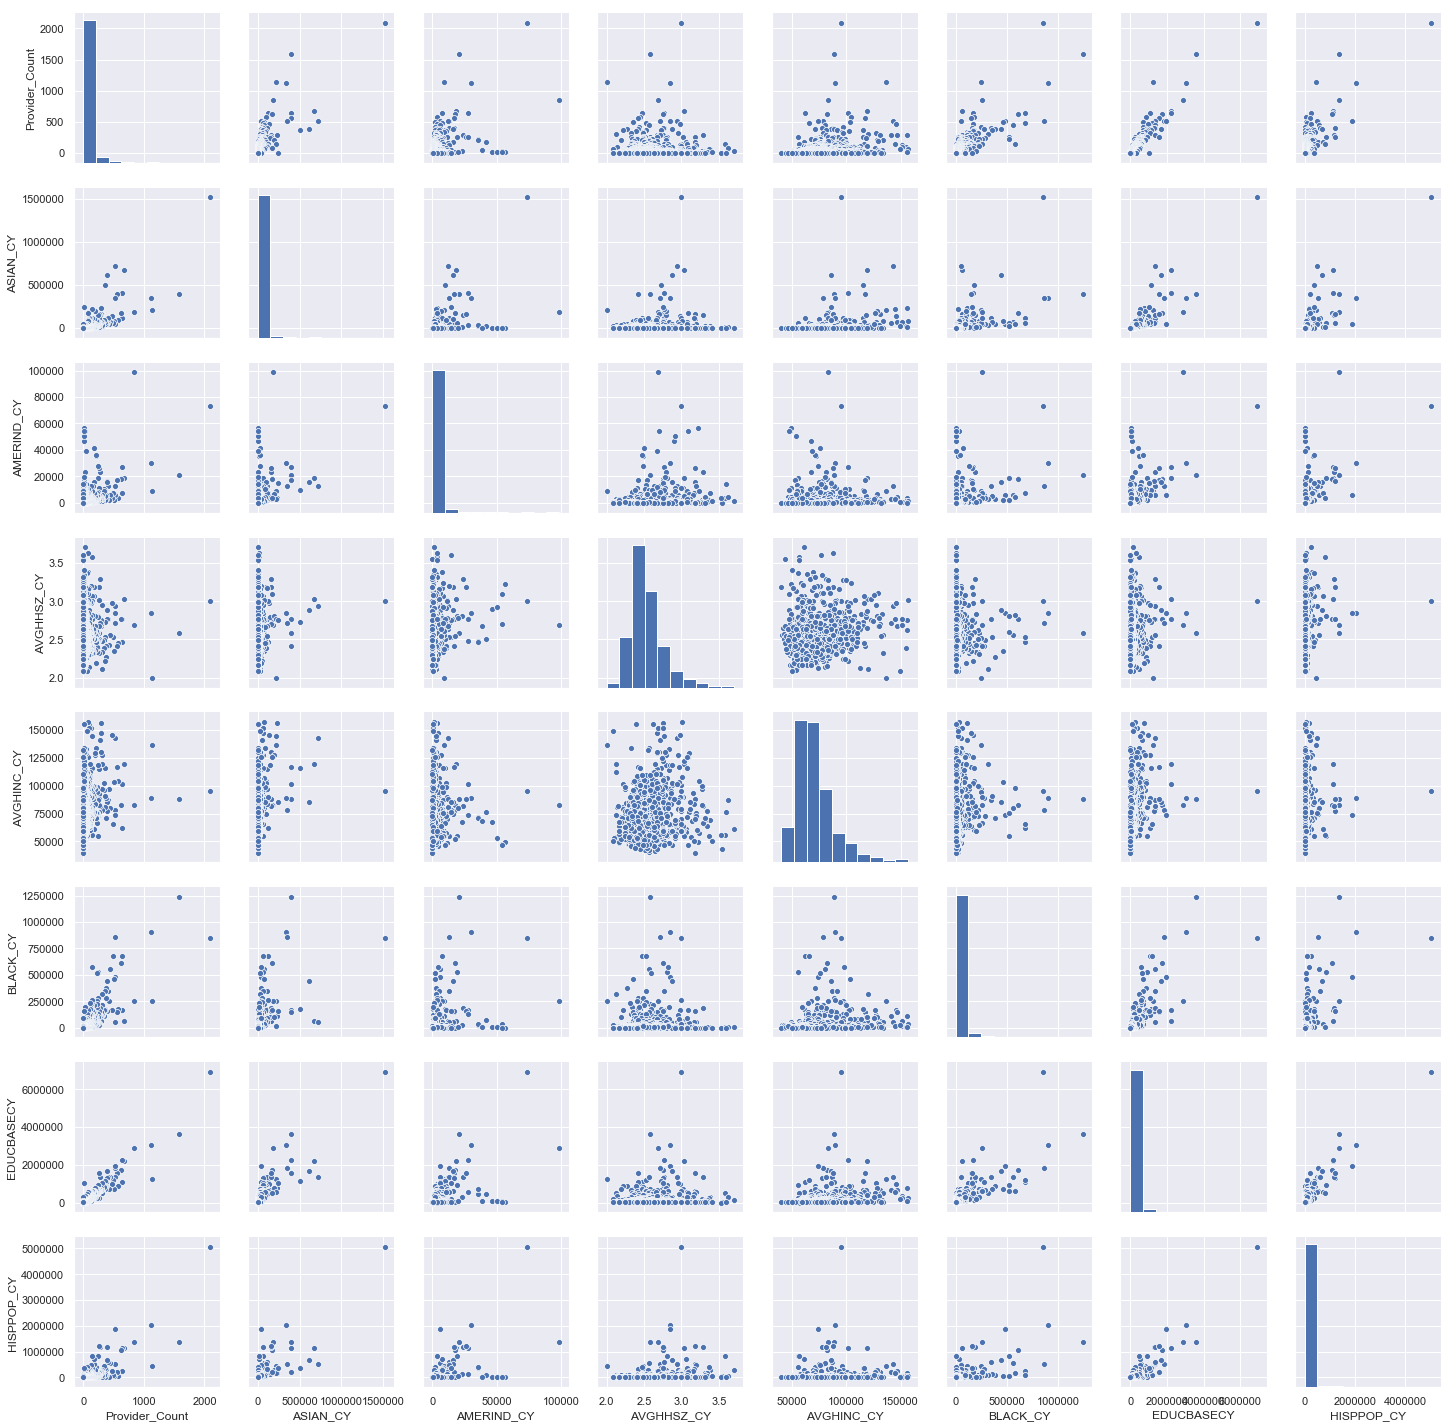

In [163]:
sns.pairplot(test_newcounty_df.iloc[:,2:10])

In [63]:
test_newcounty_df[test_newcounty_df['ASIAN_CY']>1250000]

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,CA,Los Angeles County,2094,1517296.0,73559.0,3.0,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.6,399.93,9046.16


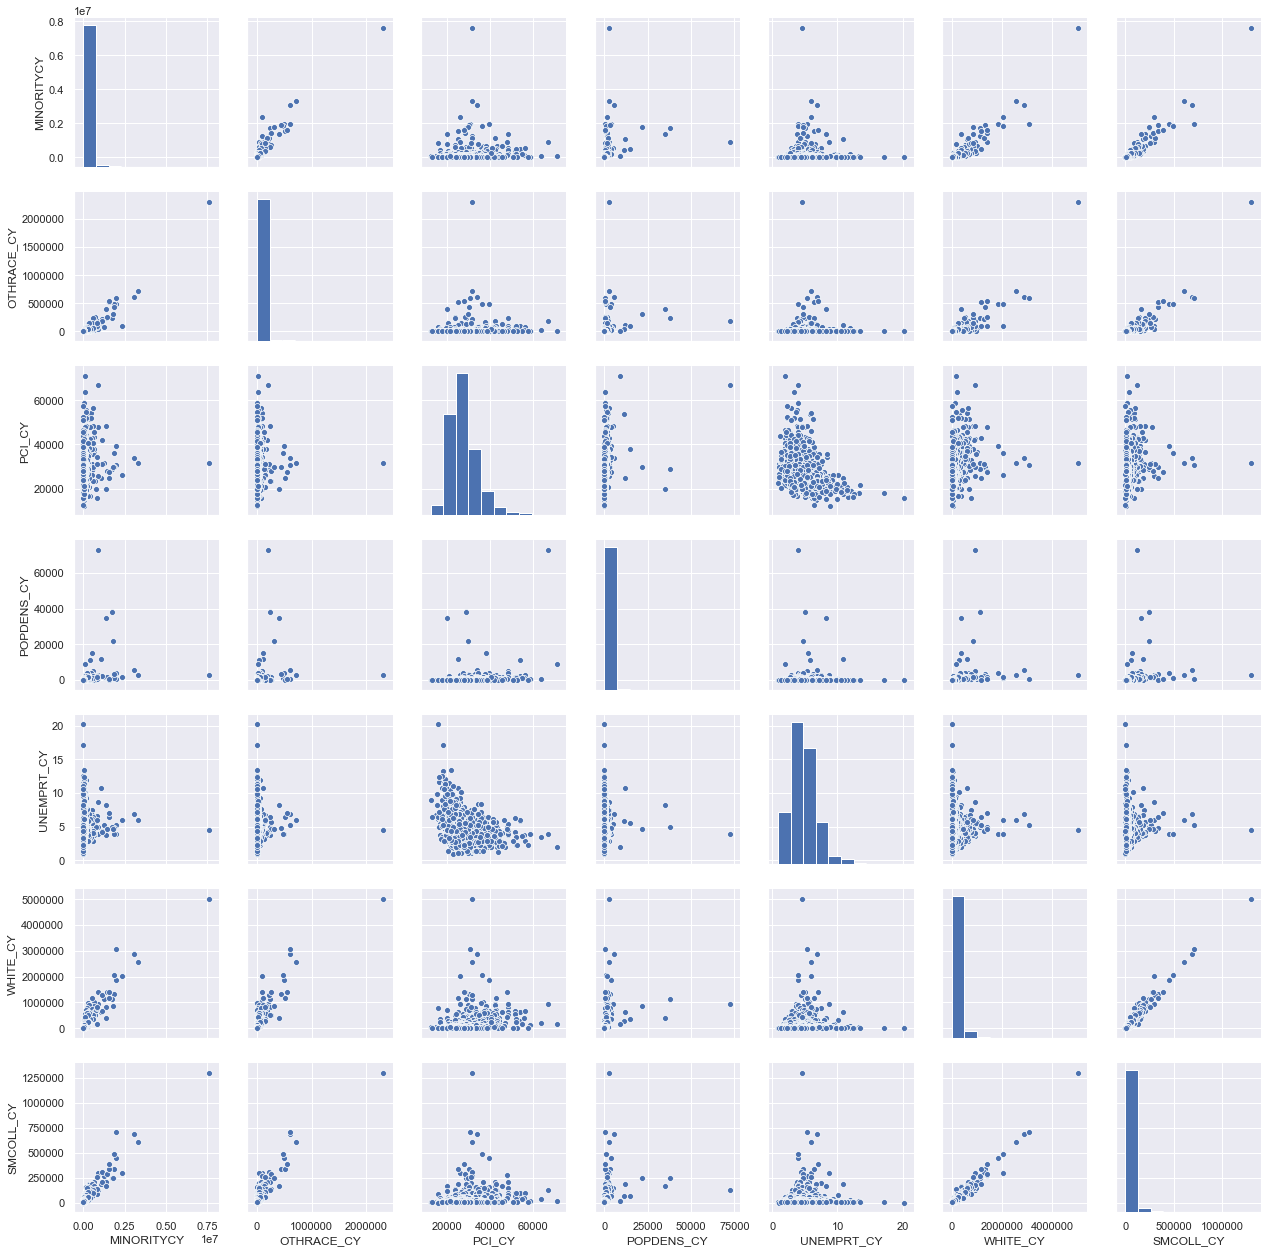

In [164]:
sns.pairplot(test_newcounty_df.iloc[:,11:18])

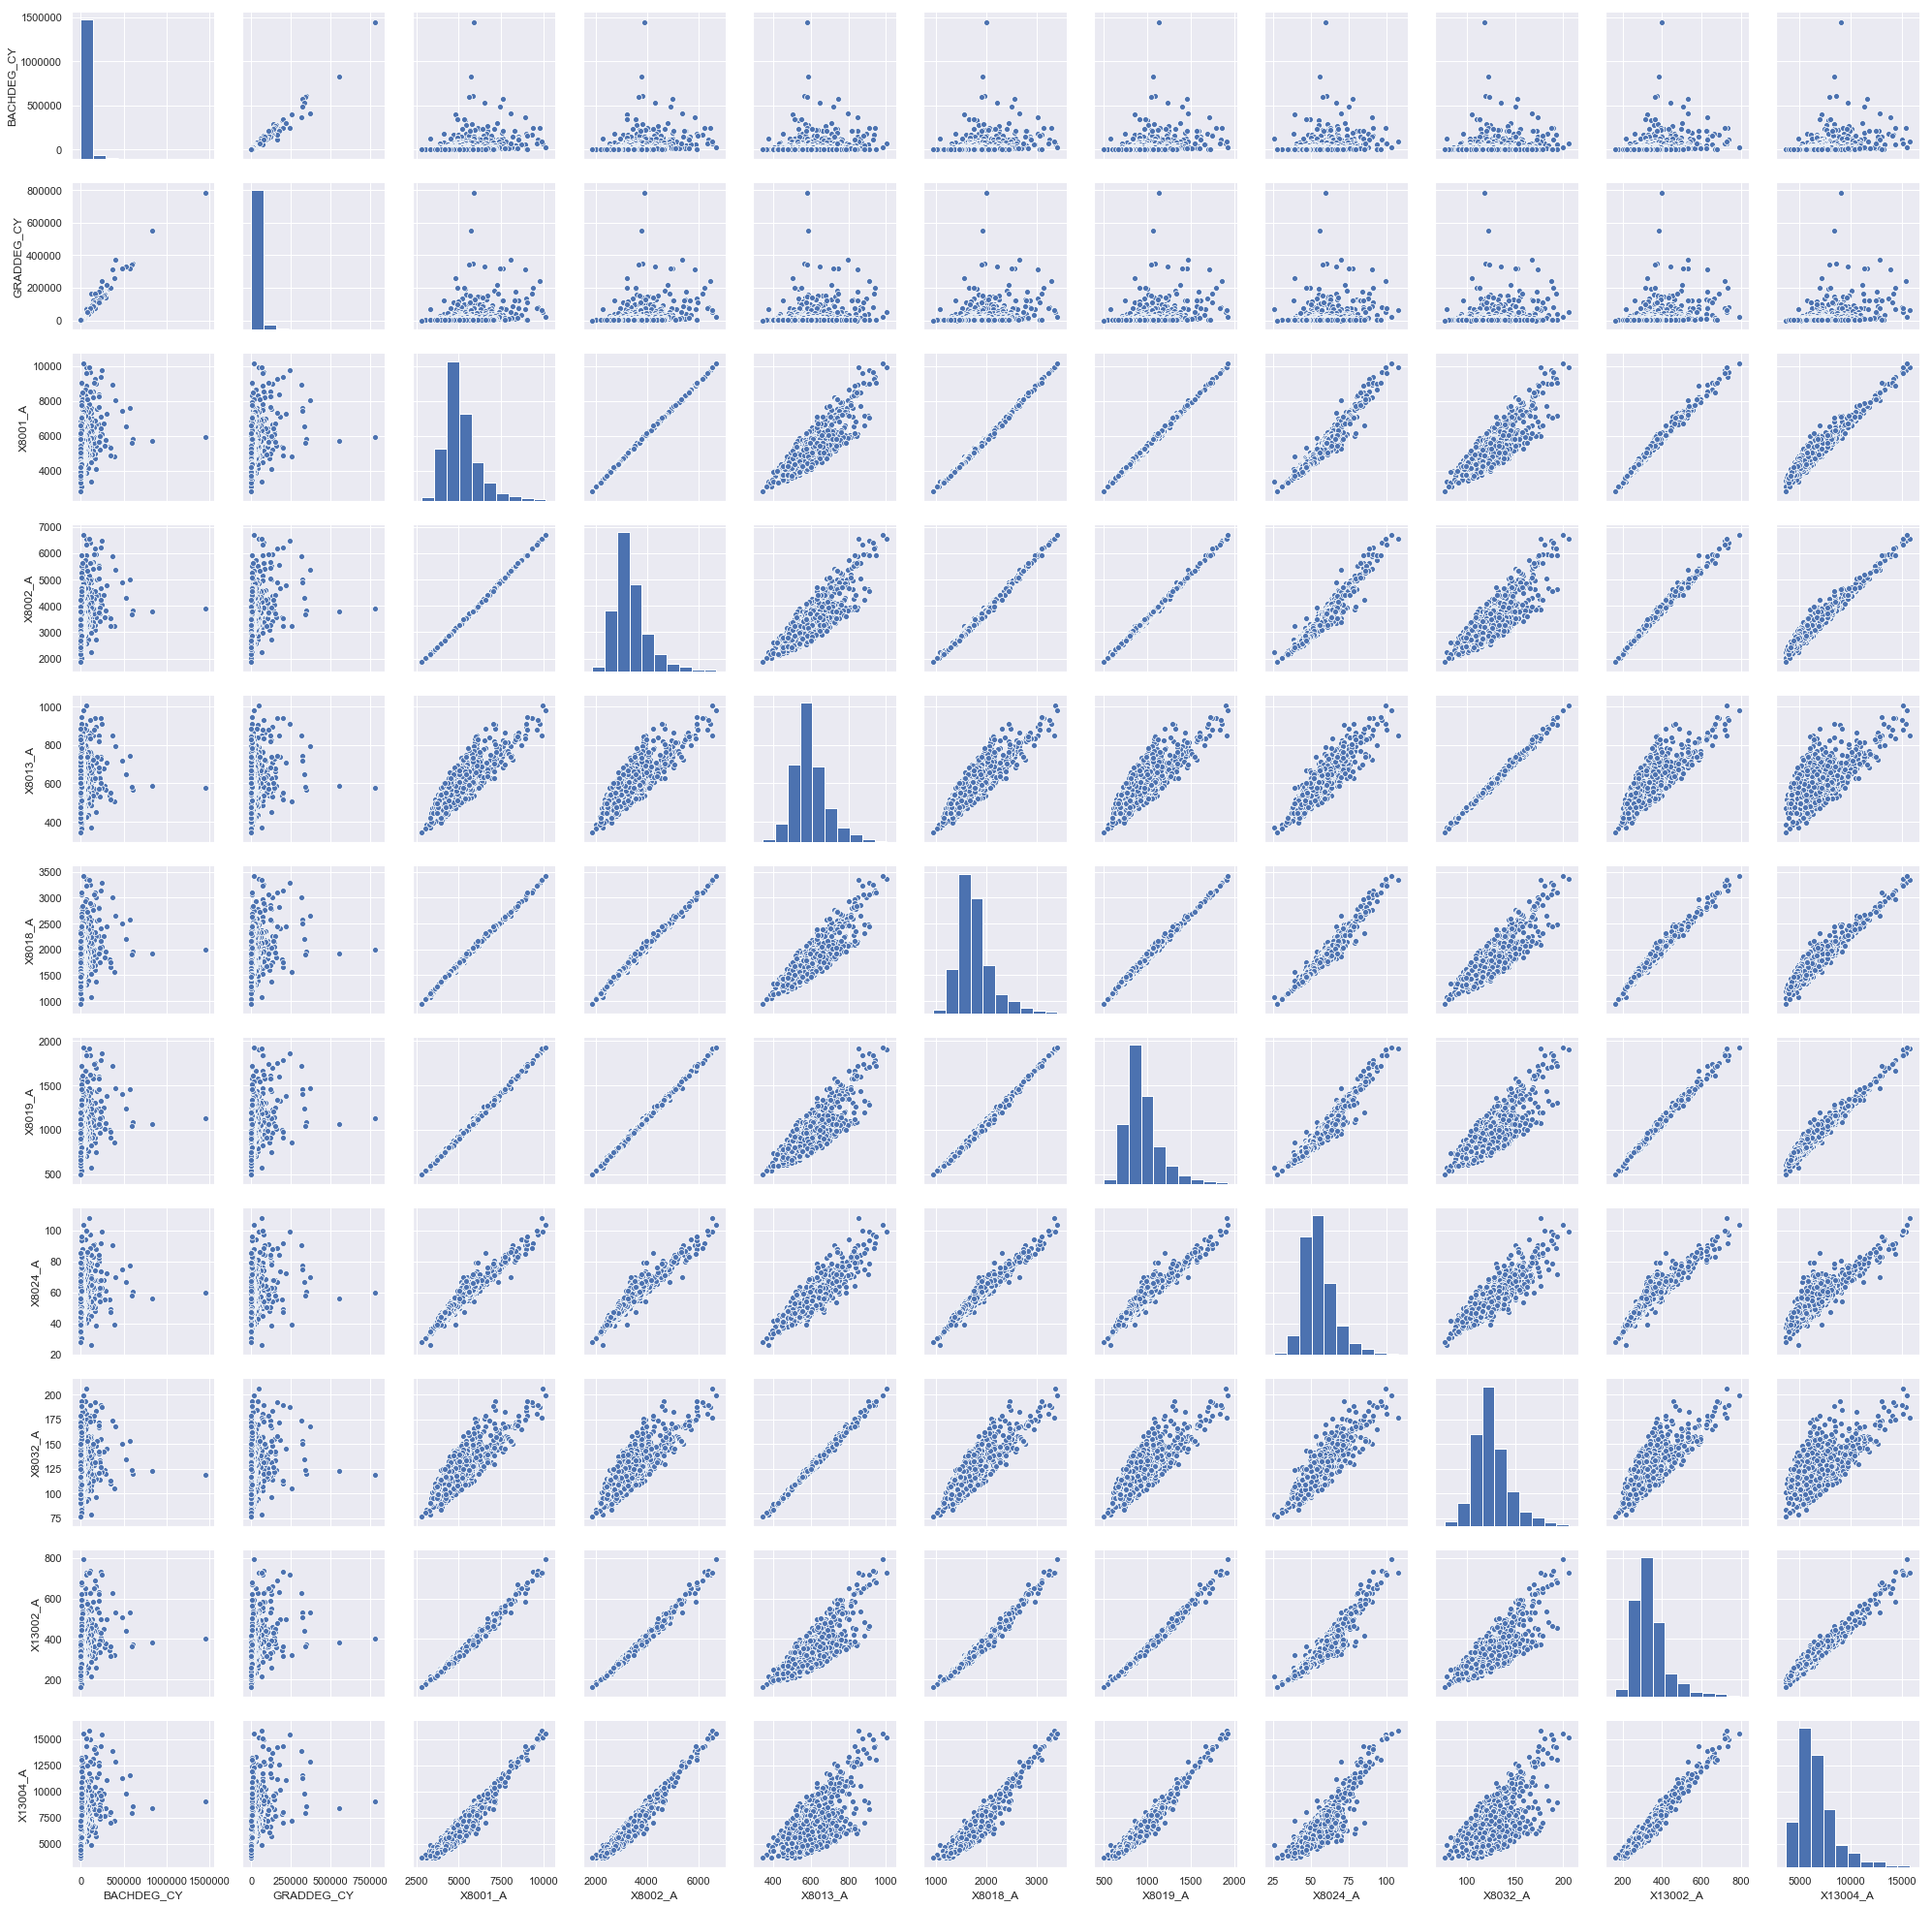

In [165]:
sns.pairplot(test_newcounty_df.iloc[:,19:])

(array([193., 132., 242., 213., 155., 101.,  62.,  42.,  13.,   4.]),
 array([0.        , 0.76468314, 1.52936628, 2.29404942, 3.05873256,
        3.8234157 , 4.58809883, 5.35278197, 6.11746511, 6.88214825,
        7.64683139]),
 <a list of 10 Patch objects>)

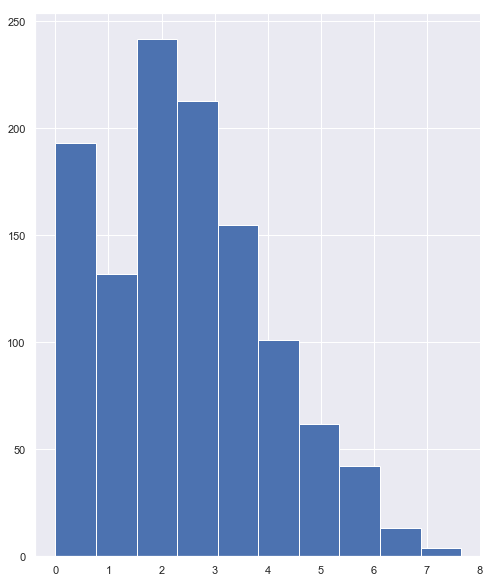

In [204]:
plt.hist(np.log(test_newcounty_df.iloc[:,2]), bins=10)

#### Correlation

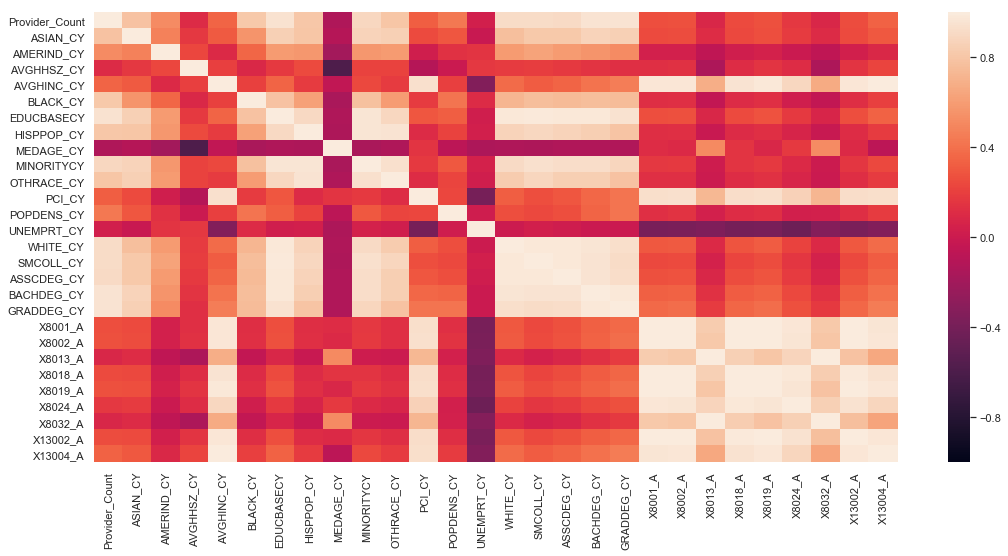

In [166]:
sns.set(rc={'figure.figsize':(18,8.27)})
# sns.heatmap(statetest3.corr().values, statetest.columns, statetest.columns, sort_f=False)
corr = test_newcounty_df.corr()
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
sns.heatmap(corr, vmin=-1.0, vmax=1.0)

In [167]:
test_newcounty_df.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,CA,Los Angeles County,2094,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,IL,Cook County,1586,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,NY,New York County,1136,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,TX,Harris County,1124,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,AZ,Maricopa County,844,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


## Run models

### Define Response and Predictor Variables

In [33]:
# Create prdictor and response variables
train_x = test_newcounty_df.iloc[:,3:]
train_y = test_newcounty_df.iloc[:,2]
train_x.head()

,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


In [34]:
train_y.head()

0    2094
1    1586
2    1136
3    1124
4     844
Name: Provider_Count, dtype: int64

### Full Model

In [152]:
import statsmodels.api as sm
import statsmodels
from statsmodels.regression import linear_model

In [153]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)
# train_x_std = pd.DataFrame(train_x_std, columns=train_x.columns)
# train_x_std.head()

#### LR using Scikit

In [154]:
# Run using scikit learn
from sklearn.linear_model import LinearRegression
lm_scaled = LinearRegression().fit(train_x_std, train_y)

In [155]:
r_sq = lm_scaled.score(train_x_std, train_y)
r_sq

0.9620517643321564

In [156]:
cdf_scaled = pd.DataFrame(lm_scaled.coef_, 
                          index=train_x.columns, columns=['coefficients'])
cdf_scaled

,coefficients
ASIAN_CY,-35.812110
AMERIND_CY,-2.135590
AVGHHSZ_CY,7.401292
AVGHINC_CY,106.714272
BLACK_CY,-4.675497
EDUCBASECY,134.690855
HISPPOP_CY,-30.255564
MEDAGE_CY,-7.168514
MINORITYCY,42.346148
OTHRACE_CY,2.416410


#### LR using Stats Models

In [157]:

Xscaled_train = train_x_std
Xscaled_train = sm.add_constant(Xscaled_train)
sm_ols = sm.OLS(train_y, Xscaled_train).fit() # i know, the param order is inverse
# sm_model = sm_ols.fit()

In [158]:
# sm_model.summary()
sm_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Provider_Count   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1060.
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:28:27   Log-Likelihood:                -5313.3
No. Observations:                1157   AIC:                         1.068e+04
Df Residuals:                    1129   BIC:                         1.082e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.2472      0.711     62.238      0.000      42.852      45.642
x1           -35.8121     13.386     -2.675      0.008     -62.077      -9.547
x2            -2.1356      1.478     -1.445      0.149      -5.035       0.764
x3             7.4013      2.311      3.202      0.001       2.867      11.936
x4           106.7143     87.480      1.220      0.223     -64.927     278.355
x5            -4.6755     14.875     -0.314      0.753     -33.861      24.510
x6           134.6909     32.438      4.152      0.000      71.046     198.335
x7           -30.2556     37.353     -0.810      0.418    -103.544      43.033
x8            -7.1685      2.017     -3.554      0.000     -11.126      -3.211
x9            42.3461     61.899      0.684      0.494     -79.104     163.796
x10            2.4164      6.115      0.395      0.693      -9.582      14.415
x11           50.3658      6.947      7.250      0.000      36.736      63.996
x12            7.6533      1.287      5.947      0.000       5.128      10.178
x13            0.9076      0.894      1.015      0.310      -0.847       2.663
x14           -2.6739     16.463     -0.162      0.871     -34.974      29.627
x15          -11.4249      8.760     -1.304      0.192     -28.612       5.763
x16          -64.9445      7.012     -9.262      0.000     -78.702     -51.187
x17            5.1255      8.468      0.605      0.545     -11.489      21.740
x18           81.0038      5.958     13.596      0.000      69.314      92.693
x19         1.689e+04   1.45e+05      0.116      0.907   -2.68e+05    3.02e+05
x20        -1.134e+04   9.69e+04     -0.117      0.907   -2.02e+05    1.79e+05
x21         -176.6202     44.381     -3.980      0.000    -263.699     -89.541
x22        -5777.1032   4.83e+04     -0.120      0.905      -1e+05    8.89e+04
x23          519.9848    104.180      4.991      0.000     315.577     724.392
x24          -28.8975     23.320     -1.239      0.216     -74.654      16.859
x25           99.8635     45.589      2.191      0.029      10.414     189.313
x26           61.6260     25.779      2.391      0.017      11.046     112.206
x27         -452.5245    103.994     -4.351      0.000    -656.567    -248.482
==============================================================================
Omnibus:                      357.654   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25889.460
Skew:                          -0.481   Prob(JB):                         0.00
Kurtosis:                      26.154   Cond. No.                     9.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.06e+05. This might i

 - Looking at the p-values, Among the coefficients, those that are statistically significant at 10% significance level are:  ASIAN_CY, AVGHHSZ_CY, EDUCBASECY, MEDAGE_CY, PCI_CY, POPDENS_CY, ASSCDEG_CY, GRADDEG_CY, X8013_A, X8019_A, X13004_A.

 - The R-squared value of 0.962 shows that 96.2% of the variability in Provider Count is explained by the model.
 
 - The p-value of F-statistic is less than 0.05 which shows that atleast one of the predicting variables has predicting power on the variability of Provider Count.
 
 - The value of Durbin-Watson test is 2.060 quite close to 2. When the value of Durbin-Watson is equal to 2, r takes the value 0 from the equation 2*(1-r),which in turn tells us that the residuals are not correlated.

##### Verify Assumptions

In [163]:
# Assumptions
pred_val = sm_ols.fittedvalues.copy()
true_val = train_y
residual = sm_ols.resid

((array([-3.23939842, -2.97735551, -2.83132703, ...,  2.83132703,
          2.97735551,  3.23939842]),
  array([-229.91427087, -194.4806102 , -140.41088764, ...,  148.84914723,
          171.6118837 ,  188.51253474])),
 (20.217420302887238, 6.021801013063496e-13, 0.8442807180606414))

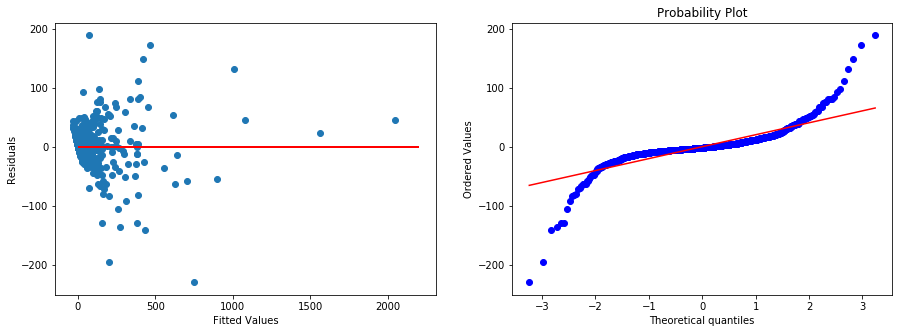

In [168]:
import scipy as sp
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

# Residuals vs Fitted
ax1.scatter(pred_val, residual)
ax1.hlines(y=0, xmin=0, xmax=2200, linewidth=2, color='r')
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')

# QQ plot
sp.stats.probplot(residual, plot=ax2, fit=True)

1. Residuals vs Fitted plot
    - **Constant Variance** - From the plot, we can see that the residuals arecloser to 0 in the beggining but values go up towards the end. This shows a violation of constant variance assumption
    - **Uncorrelated Errors** - we see that the data is clustered together and is not randomly distributed. This shows that error terms are correlated


2. Probability Plot
    - **Normality** - From this plot, we can see that the data is heavily tailed showing violations of Normality


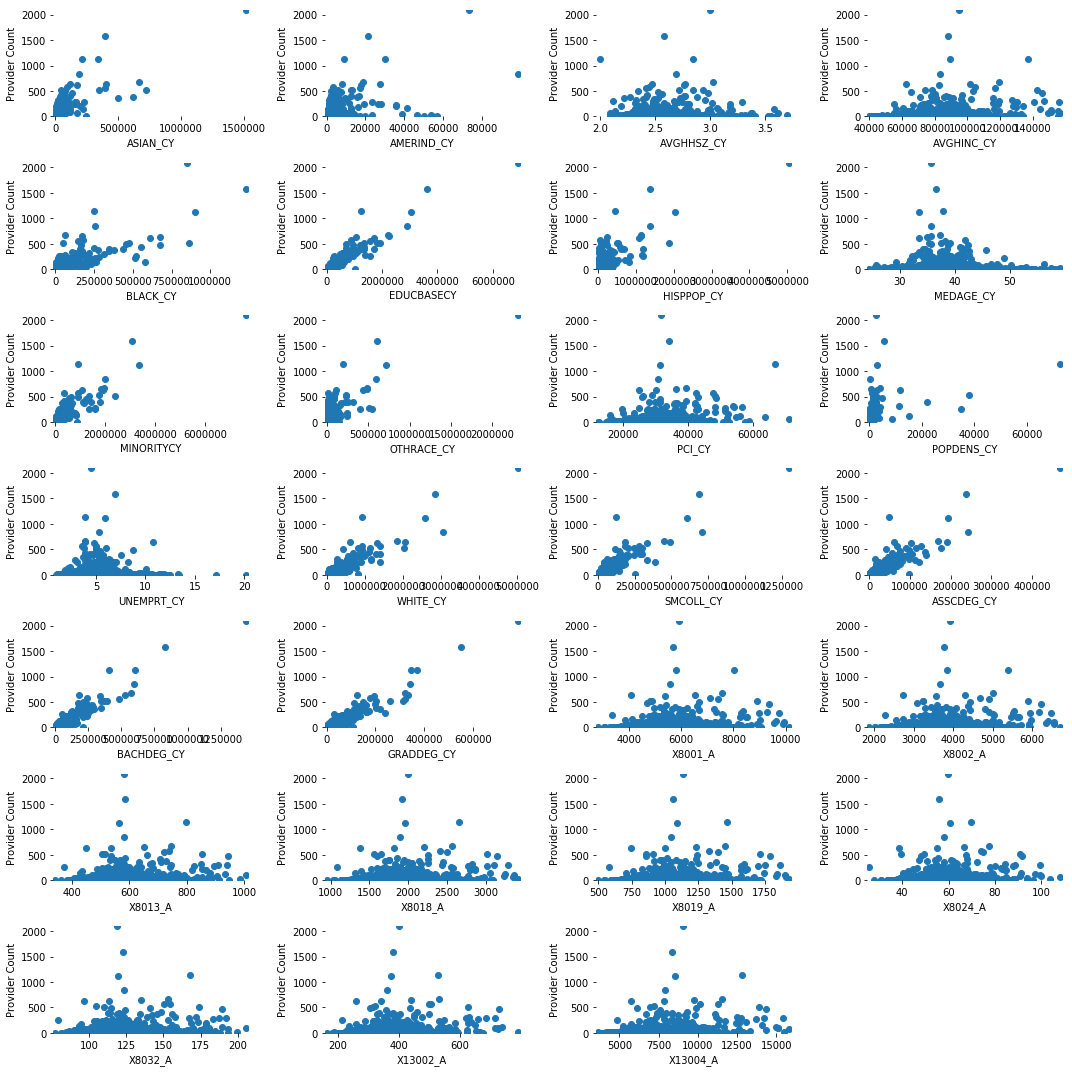

In [102]:
# Check Linearity - Plot predictors with response
states = test_newcounty_df.columns[3:]
fig = plt.figure(figsize=(15, 15))
for sp in range(0,27):
    ax = fig.add_subplot(7,4,sp+1)
#     provType = unique_df[unique_df['state']==states[sp]]['provider_type'].value_counts().reset_index()
#     ax.scatter(test_newcounty_df.iloc[:,2], test_newcounty_df.loc[:,states[sp]])
    ax.scatter(test_newcounty_df.loc[:,states[sp]], test_newcounty_df.iloc[:,2])
    ax.set_xlabel(states[sp])
    ax.set_ylabel('Provider Count')
#     ax.set_ylim(0,provType.iloc[0,1])
    plt.xticks(rotation=0)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.margins(0.01, 0)
plt.tight_layout() # automatically adjusts layout to fit long labels
plt.show()

1. Predictors vs Response
     - **Linearity** - From the plot above, we can see the each predictor variable is either strongly or weakly related to response variable. From this plot, we can sya that the Linearity assumption holds.

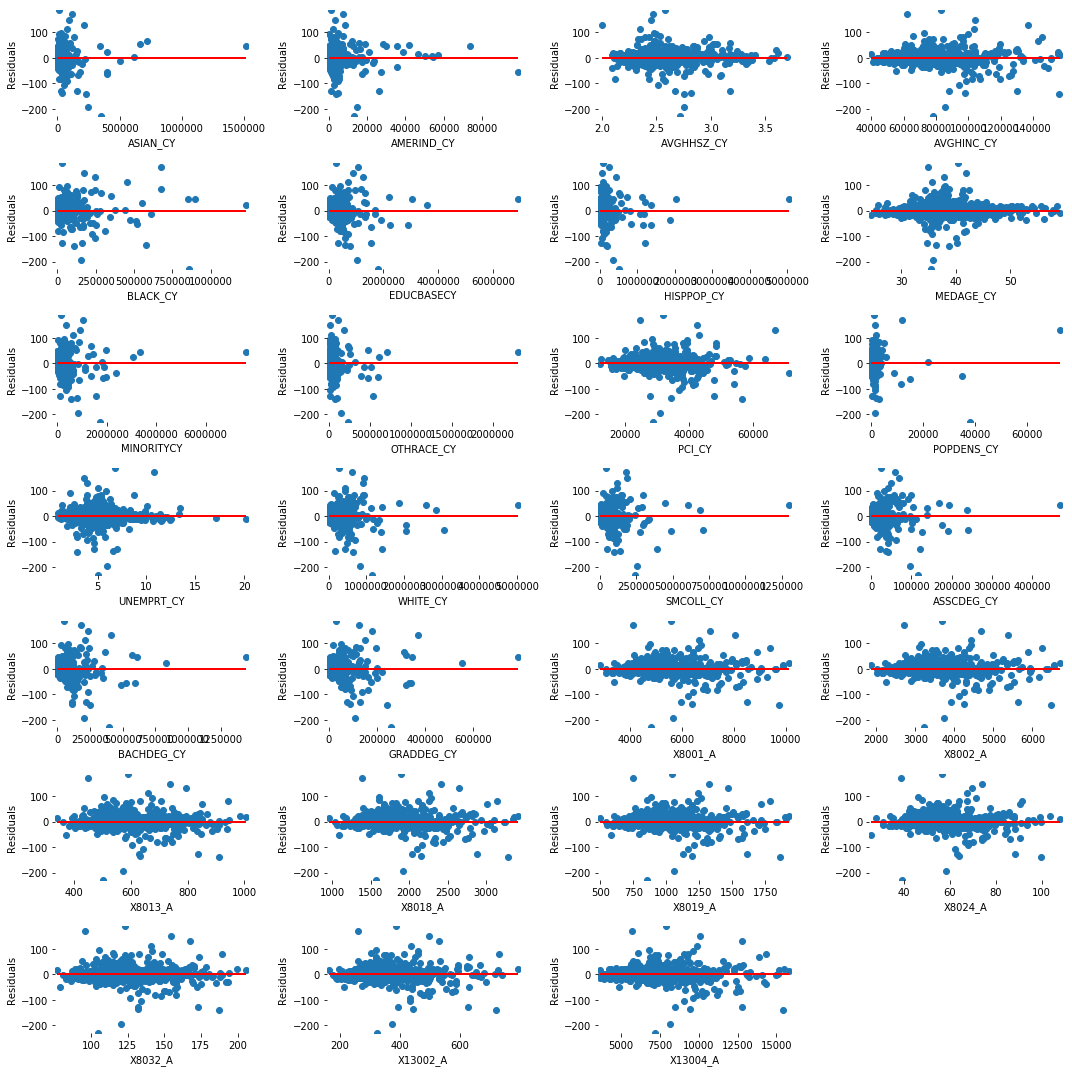

In [106]:
# Check Linearity - Plot predictors with residuals
states = test_newcounty_df.columns[3:]
fig = plt.figure(figsize=(15, 15))

for sp in range(0,27):
    mini = min(test_newcounty_df.loc[:,states[sp]])
    maxi = max(test_newcounty_df.loc[:,states[sp]])
    ax = fig.add_subplot(7,4,sp+1)
    ax.scatter(test_newcounty_df.loc[:,states[sp]], residual)
    ax.hlines(y=0, xmin=mini, xmax=maxi, linewidth=2, color='r')
    ax.set_xlabel(states[sp])
    ax.set_ylabel('Residuals')
#     ax.set_ylim(0,provType.iloc[0,1])
    plt.xticks(rotation=0)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.margins(0.01, 0)
plt.tight_layout() # automatically adjusts layout to fit long labels
plt.show()

In [123]:
test_newcounty_df.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,CA,Los Angeles County,2094,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,IL,Cook County,1586,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,NY,New York County,1136,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,TX,Harris County,1124,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,AZ,Maricopa County,844,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


In [133]:
test_LA = test_newcounty_df.copy()
test_LA.drop([0,1,2,3], axis=0, inplace=True)

In [134]:
test_LA.head()

,regionabbr,subregion,Provider_Count,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
4,AZ,Maricopa County,844,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62
5,CA,Orange County,668,667421.0,18749.0,3.03,119319.0,59756.0,2214866.0,1128550.0,37.3,1955996.0,486147.0,39365.0,4116.0,3.9,1856948.0,446651.0,169405.0,569544.0,319520.0,7570.07,5001.41,743.94,2568.66,1452.60,77.57,152.87,532.04,11559.94
6,CA,San Diego County,646,401095.0,27438.0,2.77,101373.0,168807.0,2246969.0,1144104.0,35.7,1844110.0,483908.0,36291.0,795.0,3.9,2056884.0,487496.0,191669.0,525473.0,331783.0,6514.21,4306.51,649.22,2207.70,1234.01,66.80,135.09,439.85,9730.65
7,PA,Philadelphia County,636,118378.0,7744.0,2.47,62170.0,673651.0,1063143.0,243837.0,34.9,1053483.0,117203.0,24833.0,11869.9,10.8,618922.0,182434.0,60266.0,180690.0,124886.0,4098.74,2718.86,450.21,1379.88,745.46,38.77,96.20,258.96,5711.26
8,TX,Dallas County,623,170268.0,17668.0,2.76,82550.0,608225.0,1709385.0,1072941.0,33.6,1890363.0,436469.0,29987.0,3046.4,4.8,1335362.0,332724.0,102480.0,337376.0,193333.0,5366.30,3553.67,534.73,1812.63,1000.06,55.22,113.62,342.48,7832.26


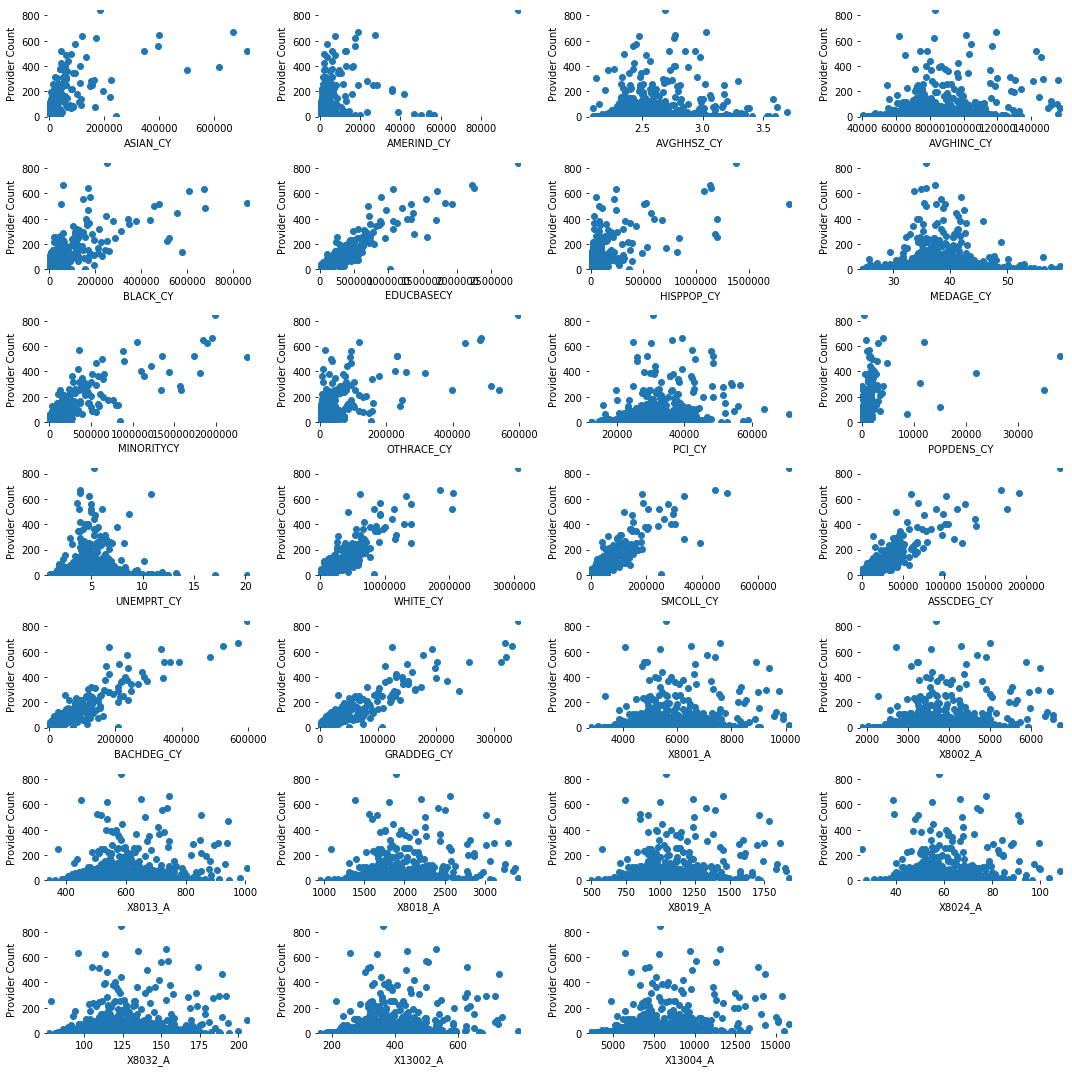

In [135]:
# Check Linearity - Plot predictors with response
states = test_LA.columns[3:]
fig = plt.figure(figsize=(15, 15))
for sp in range(0,27):
    ax = fig.add_subplot(7,4,sp+1)
#     provType = unique_df[unique_df['state']==states[sp]]['provider_type'].value_counts().reset_index()
#     ax.scatter(test_newcounty_df.iloc[:,2], test_newcounty_df.loc[:,states[sp]])
    ax.scatter(test_LA.loc[:,states[sp]], test_LA.iloc[:,2])
    ax.set_xlabel(states[sp])
    ax.set_ylabel('Provider Count')
#     ax.set_ylim(0,provType.iloc[0,1])
    plt.xticks(rotation=0)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.margins(0.01, 0)
plt.tight_layout() # automatically adjusts layout to fit long labels
plt.show()

##### Outlier Detection

One way to think about whether or not the results you have were driven by a given data point is to calculate how far the predicted values for data would move if model was fit without the data point in question. This calculated total distance is called Cook's distance. Cook's D is a function of the leverage and standardized residual associated with each data point.

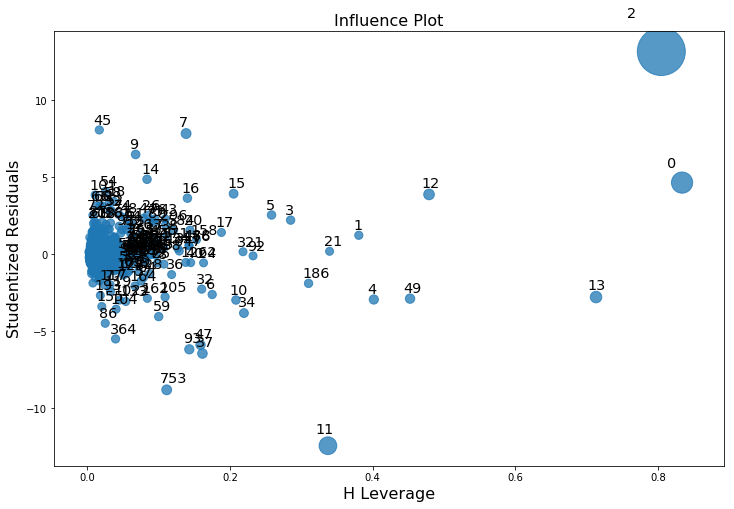

In [170]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(sm_ols, ax= ax, criterion="cooks")

From this plot, we can see that points towards the right (2, 0, 13) are away from both x and y axis and hence are influential points. Points 12, 49 and 11 are a little further from the axes but not as much as 2 and can be considered outliers.

#### LR using r

In [47]:
import rpy2.ipython
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [51]:
X = pd.DataFrame(train_x_std, columns=train_x.columns)
y = pd.Series(train_y, name='Provider_COunt')

In [62]:
%%R -i X -i y

lin_reg <- lm(y ~ ., data = cbind(X, y))
print(summary(lin_reg))

In [108]:
%%R
summary(lin_reg)

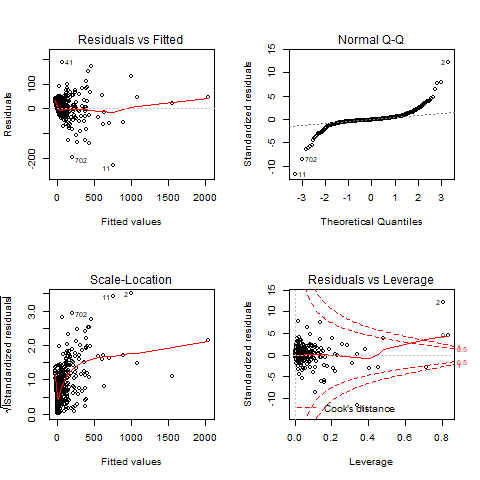

In [61]:
%%R

par(mfrow=c(2,2))  # set 2 rows and 2 column plot layout
plot(lin_reg)

In [ ]:
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
R = ro.r

# df = pd.DataFrame({'x': [1,2,3,4,5], 
#                    'y': [2,1,3,5,4]})

M = R.lm('~x', data=tra)
print(R.summary(M).rx2('coefficients'))

### Identify Best Model

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [171]:
# # Test options and evaluation metric
# num_folds = 10
# seed = 7
# scoring ='neg_mean_squared_error'

In [73]:
# Spot-Check Algorithms
# models = []
# models.append(('LR', LinearRegression()))
# models.append(('LASSO', Lasso()))
# models.append(('EN', ElasticNet()))
# models.append(('KNN', KNeighborsRegressor()))
# models.append(('CART', DecisionTreeRegressor()))
# models.append(('SVR', SVR()))

In [74]:
# # evaluate each model in turn
# results = []
# names = []
# for name, model in models:
#     kfold = KFold(n_splits=num_folds, random_state=seed)
#     cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

LR: -2680.029532 (10579.571289)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164348.74231300407, tolerance: 181.6051318918919
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534720.3922966116, tolerance: 1649.2245639639639
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563787.4438992534, tolerance: 1723.123468108108
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skle

LASSO: -2448.143916 (9619.786419)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581995.4356041537, tolerance: 1739.40044
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 587896.8705070689, tolerance: 1738.4907377477475
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581537.0129763272, tolerance: 1737.763107650765
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\line

EN: -2452.245213 (9644.610678)
KNN: -10222.686687 (46339.033909)
CART: -10267.503460 (44575.962852)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  

SVR: -16034.735351 (69590.666833)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


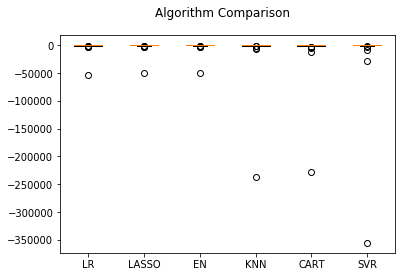

In [75]:
# # Compare Algorithms
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

In [143]:
# Create prdictor and response variables
train_x = test_newcounty_df.iloc[:,3:]
train_y = test_newcounty_df.iloc[:,2]
train_x.head()

,ASIAN_CY,AMERIND_CY,AVGHHSZ_CY,AVGHINC_CY,BLACK_CY,EDUCBASECY,HISPPOP_CY,MEDAGE_CY,MINORITYCY,OTHRACE_CY,PCI_CY,POPDENS_CY,UNEMPRT_CY,WHITE_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY,GRADDEG_CY,X8001_A,X8002_A,X8013_A,X8018_A,X8019_A,X8024_A,X8032_A,X13002_A,X13004_A
0,1517296.0,73559.0,3.00,94861.0,850350.0,6899087.0,5043293.0,35.7,7644196.0,2305030.0,31563.0,2535.5,4.5,5019340.0,1300786.0,469649.0,1445895.0,782758.0,5905.52,3907.44,579.43,1998.08,1132.94,59.76,118.60,399.93,9046.16
1,395712.0,21113.0,2.58,88254.0,1233716.0,3607345.0,1374256.0,36.6,3078944.0,608672.0,34083.0,5579.2,6.9,2859209.0,690225.0,237028.0,830433.0,552050.0,5692.87,3774.06,585.60,1918.81,1061.74,56.05,122.50,381.05,8356.49
2,212844.0,8756.0,2.00,136860.0,247085.0,1251653.0,441304.0,37.9,899778.0,193191.0,66805.0,72736.2,3.9,924396.0,121070.0,48360.0,406878.0,371255.0,8035.56,5382.10,796.17,2653.46,1464.96,69.80,167.61,530.01,12793.70
3,341640.0,30001.0,2.85,89252.0,901459.0,3029538.0,2035551.0,33.5,3339578.0,712410.0,31405.0,2780.1,5.9,2573473.0,606842.0,193511.0,605813.0,345886.0,5800.32,3840.81,564.48,1959.50,1087.37,60.64,119.69,374.86,8547.08
4,184150.0,98584.0,2.69,83005.0,253576.0,2891837.0,1373153.0,35.8,1981147.0,598035.0,30701.0,476.9,5.3,3066684.0,711033.0,241714.0,597653.0,342159.0,5574.19,3675.76,581.95,1898.43,1041.69,57.84,123.67,362.02,7908.62


In [144]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring ='neg_mean_squared_error'

In [145]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('Ridge',Ridge())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))
# pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor(n_estimators = 100))])))

In [146]:
import math
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, math.sqrt(abs(cv_results.mean())), cv_results.std())
    print(msg)
#     print("RMSE: %.3f" % (math.sqrt(abs(cv_results.mean()))))

ScaledLR: 69.509243 (13736.022485)
ScaledLASSO: 68.587369 (13434.955271)
ScaledEN: 68.741112 (13378.275884)
ScaledRidge: 67.255591 (12868.089448)
ScaledKNN: 114.456716 (38181.824612)
ScaledCART: 119.244079 (40704.000975)
ScaledSVR: 123.173309 (44776.359243)


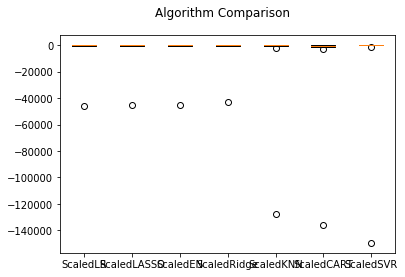

In [147]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Ensemble Models

In [175]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [176]:
ensemble = []
ensemble.append(('ScaledAB',Pipeline([('Scalar',StandardScaler()),('AB',AdaBoostRegressor())])))
ensemble.append(('ScaledGB',Pipeline([('Scalar',StandardScaler()),('AB',GradientBoostingRegressor())])))
ensemble.append(('ScaledRF',Pipeline([('Scalar',StandardScaler()),('AB',RandomForestRegressor(n_estimators=10))])))
ensemble.append(('ScaledET',Pipeline([('Scalar',StandardScaler()),('AB',ExtraTreesRegressor(n_estimators=10))])))

In [177]:
import math
results = []
names = []
for name, model in ensemble:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, math.sqrt(abs(cv_results.mean())), cv_results.std())
    print(msg)

ScaledAB: 121.154282 (40507.045559)
ScaledGB: 118.122984 (40971.205377)
ScaledRF: 115.705741 (39125.193651)
ScaledET: 120.559273 (42396.388592)


### Run Random Forest

In [93]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [94]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_x.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: EDUCBASECY           Importance: 0.63
Variable: WHITE_CY             Importance: 0.1
Variable: MINORITYCY           Importance: 0.07
Variable: OTHRACE_CY           Importance: 0.05
Variable: HISPPOP_CY           Importance: 0.03
Variable: ASIAN_CY             Importance: 0.02
Variable: BLACK_CY             Importance: 0.02
Variable: POPDENS_CY           Importance: 0.02
Variable: AMERIND_CY           Importance: 0.01
Variable: AVGHHSZ_CY           Importance: 0.01
Variable: PCI_CY               Importance: 0.01
Variable: AVGHINC_CY           Importance: 0.0
Variable: MEDAGE_CY            Importance: 0.0
Variable: UNEMPRT_CY           Importance: 0.0
Variable: X8001_A              Importance: 0.0
Variable: X8002_A              Importance: 0.0
Variable: X8013_A              Importance: 0.0
Variable: X8018_A              Importance: 0.0
Variable: X8019_A              Importance: 0.0
Variable: X8024_A              Importance: 0.0
Variable: X8032_A              Importance: 0.0
Var

### Run LR

In [244]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)

In [245]:
import math
kfold = KFold(n_splits=10, random_state=7)
model = LinearRegression()
results = cross_val_score(model, train_x_std, train_y, cv=kfold, scoring='neg_mean_squared_error')
print("Negative MSE: %.3f (%.3f)" % (results.mean(), results.std()))
print("RMSE: %.3f" % (math.sqrt(abs(results.mean()))))

Negative MSE: -4831.535 (13736.022)
RMSE: 69.509


In [243]:
model.get_params

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>

In [242]:
coef = pd.Series(model.coef_, index = train_x.columns)
imp_coef = pd.concat([coef.sort_values(ascending=False)])
imp_coef

AttributeError: 'LinearRegression' object has no attribute 'coef_'

### Run Ridge

In [186]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)

In [187]:
from sklearn.linear_model import Ridge
ridge_model=Ridge()
ridge_model.fit(train_x_std,train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [188]:
coef = pd.Series(ridge_model.coef_, index = train_x.columns)
print("Lasso model picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso model picked 27 variables and eliminated the other 0 variables


In [190]:
imp_coef = pd.concat([coef.sort_values(ascending=False)])
imp_coef

GRADDEG_CY    77.239684
EDUCBASECY    68.738600
X8019_A       51.208393
PCI_CY        36.519822
X8018_A       29.029839
WHITE_CY      19.454203
X13002_A      13.596778
BLACK_CY      12.973936
OTHRACE_CY    12.243136
BACHDEG_CY     9.790354
AVGHHSZ_CY     5.667606
POPDENS_CY     4.967631
MINORITYCY     1.426801
UNEMPRT_CY     0.561316
X8032_A        0.018115
AMERIND_CY    -1.456211
SMCOLL_CY     -2.470270
X8001_A       -3.608464
MEDAGE_CY     -4.718549
HISPPOP_CY    -6.838733
X8024_A       -6.981113
X8013_A      -17.628532
ASIAN_CY     -19.852558
X8002_A      -19.854157
X13004_A     -42.277273
ASSCDEG_CY   -49.270634
AVGHINC_CY   -52.111574
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

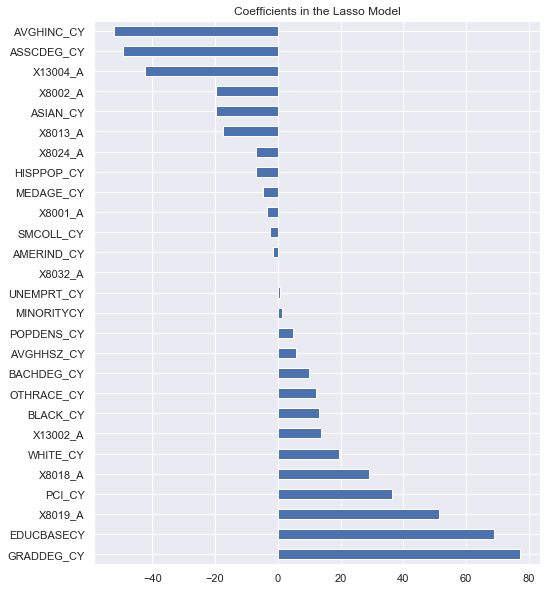

In [191]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

From the analysis above, we can see that factors that are predictive of higher provider count are:
- GRADDEG_CY (2018 Education: Graduate/Professional Degree (Esri))
- HINC15_CY (Household Income $15000 - $24999 (Esri))
- POPDENS_CY (2018 Population Density (Pop per Square Mile) (Esri))
- UNEMP_CY (2018 Unemployed Population Age 16+ (Esri))
- NHSPBLK_CY (2018 Black/African American Non-Hispanic Population (Esri))
- AGGINC_CY (2018 Aggregate Income (Esri))
- AGGHINC_CY (2018 Aggregate Household Income (Esri))
- HINC0_CY (Household Income less than $15000 (Esri))
- GQPOP_CY (2018 Group Quarters Population (Esri))
- HISPOTH_CY (2018 Hispanic Other Race Population (Esri))

Factors that negatively influence provider count are:
- HISPBLK_CY (2018 Hispanic Black/African American Population (Esri))
- NHSPOTH_CY (2018 Other Race Non-Hispanic Population (Esri))
- PIFBASE_CY (2018 Pacific Islander Female Population by Age Base (Esri))

### Run Lasso

In [178]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)

In [179]:
from sklearn.linear_model import Lasso
lasso_model=Lasso()
lasso_model.fit(train_x_std,train_y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [180]:
coef = pd.Series(lasso_model.coef_, index = train_x.columns)
print("Lasso model picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso model picked 10 variables and eliminated the other 17 variables


In [183]:
imp_coef = pd.concat([coef.sort_values(ascending=False).head(5),
                     coef.sort_values(ascending=False).tail(5)])
imp_coef

GRADDEG_CY    82.987999
BLACK_CY      19.755163
WHITE_CY      16.722833
OTHRACE_CY    13.113681
POPDENS_CY     5.201864
X8002_A       -0.224959
AVGHINC_CY    -0.267816
AVGHHSZ_CY    -2.380260
X13002_A      -4.923722
ASIAN_CY      -8.386470
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

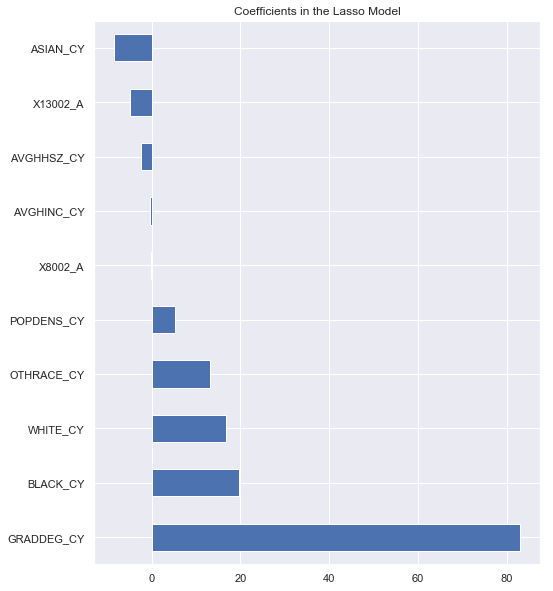

In [184]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Run Elastic Net

ElasticNet combines the properties of both Ridge and LASSO regression.  It seeks to minimize the complexity of the model (magnitude  and  number  of  regression  coefficients)  by  penalizing  the  model  using  both  the L2-norm (sum squared coefficient values) and the L1-norm (sum absolute coefficient values).

In [192]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
from scipy import stats
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)

In [193]:
from sklearn.linear_model import Lasso
elastic_model=ElasticNet()
elastic_model.fit(train_x_std,train_y)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [194]:
coef = pd.Series(elastic_model.coef_, index = train_x.columns)
print("ElasticNet model picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

ElasticNet model picked 20 variables and eliminated the other 7 variables


In [199]:
coef

ASIAN_CY       3.947739
AMERIND_CY     1.408611
AVGHHSZ_CY    -4.172749
AVGHINC_CY     0.453336
BLACK_CY      15.468153
EDUCBASECY    11.774654
HISPPOP_CY     4.213778
MEDAGE_CY     -1.883922
MINORITYCY     7.671412
OTHRACE_CY     4.555564
PCI_CY         3.504828
POPDENS_CY     9.963559
UNEMPRT_CY     1.127128
WHITE_CY      12.620984
SMCOLL_CY      9.748853
ASSCDEG_CY     7.980145
BACHDEG_CY    14.850023
GRADDEG_CY    18.869037
X8001_A        0.000000
X8002_A        0.000000
X8013_A       -0.000000
X8018_A       -0.000000
X8019_A        0.000000
X8024_A       -0.620345
X8032_A       -0.000000
X13002_A      -0.000000
X13004_A       0.058779
dtype: float64

In [197]:
imp_coef = pd.concat([coef.sort_values(ascending=False).head(17),
                     coef.sort_values(ascending=False).tail(3)])
imp_coef

GRADDEG_CY    18.869037
BLACK_CY      15.468153
BACHDEG_CY    14.850023
WHITE_CY      12.620984
EDUCBASECY    11.774654
POPDENS_CY     9.963559
SMCOLL_CY      9.748853
ASSCDEG_CY     7.980145
MINORITYCY     7.671412
OTHRACE_CY     4.555564
HISPPOP_CY     4.213778
ASIAN_CY       3.947739
PCI_CY         3.504828
AMERIND_CY     1.408611
UNEMPRT_CY     1.127128
AVGHINC_CY     0.453336
X13004_A       0.058779
X8024_A       -0.620345
MEDAGE_CY     -1.883922
AVGHHSZ_CY    -4.172749
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

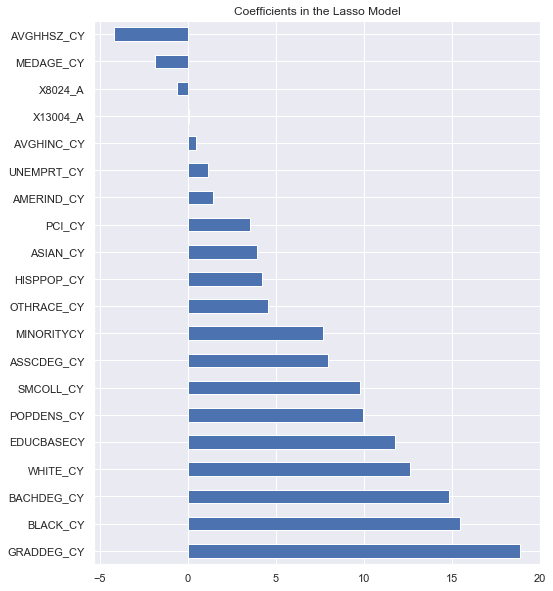

In [198]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Add new columns - Provider Density

In [63]:
add_columns_df = test_newcounty_df.copy()

In [64]:
add_columns_df['WhitePop_Density'] = add_columns_df['WHITE_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['BlackPop_Density'] = add_columns_df['BLACK_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['WhitePop_Density'] = add_columns_df['WHITE_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['AmeIndPop_Density'] = add_columns_df['AMERIND_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['AsianPop_Density'] = add_columns_df['ASIAN_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['PacificPop_Density'] = add_columns_df['PACIFIC_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['OtherPop_Density'] = add_columns_df['OTHRACE_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['HispanicPop_Density'] = add_columns_df['HISPPOP_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['Provider_Density'] = add_columns_df['Provider_Count']/add_columns_df['TOTPOP_CY']

In [65]:
# Check Datatypes of different columns
g = add_columns_df.columns.to_series().groupby(add_columns_df.dtypes).groups
g

{dtype('int64'): Index(['Provider_Count'], dtype='object'),
 dtype('float64'): Index(['AAGEBASECY', 'AGGDI_CY', 'AGGHINC_CY', 'AGGINC_CY', 'AGGNW_CY',
        'AIFBASE_CY', 'AIMBASE_CY', 'AMERIND_CY', 'AREA', 'ASIAN_CY',
        ...
        'WHTMBASECY', 'WIDOWED_CY', 'WhitePop_Density', 'BlackPop_Density',
        'AmeIndPop_Density', 'AsianPop_Density', 'PacificPop_Density',
        'OtherPop_Density', 'HispanicPop_Density', 'Provider_Density'],
       dtype='object', length=179),
 dtype('O'): Index(['RegionAbbr', 'Subregion'], dtype='object')}

In [66]:
add_columns_df.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY,WhitePop_Density,BlackPop_Density,AmeIndPop_Density,AsianPop_Density,PacificPop_Density,OtherPop_Density,HispanicPop_Density,Provider_Density
0,CA,Los Angeles County,2094,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0,0.487839,0.082647,0.007149,0.147469,0.002647,0.224030,0.490167,0.000204
1,IL,Cook County,1586,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.

#### Define Response and Predictor Variables

In [79]:
# Create prdictor and response variables
train_x = add_columns_df.iloc[:,3:-1]
train_y = add_columns_df.iloc[:,-1]
train_x.head()

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY,WhitePop_Density,BlackPop_Density,AmeIndPop_Density,AsianPop_Density,PacificPop_Density,OtherPop_Density,HispanicPop_Density
0,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0,0.487839,0.082647,0.007149,0.147469,0.002647,0.224030,0.490167
1,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187

In [80]:
train_x.shape

(1157, 178)

In [81]:
train_y.head()

0    0.000204
1    0.000301
2    0.000684
3    0.000237
4    0.000192
Name: Provider_Density, dtype: float64

#### Identify Best Model

In [82]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring ='neg_mean_squared_error'

In [83]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [84]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.000000 (0.000000)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.315384803230892e-06, tolerance: 1.47446680422909e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.173040652991125e-06, tolerance: 1.1016880992866113e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.995571428473911e-06, tolerance: 1.6678652527430239e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis

LASSO: -0.000000 (0.000000)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.92841577466613e-06, tolerance: 1.6678652527430239e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.953424049941943e-06, tolerance: 1.6735099171517605e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.881782928385075e-06, tolerance: 1.6639492179839088e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgi

EN: -0.000000 (0.000000)
KNN: -0.000000 (0.000000)
CART: -0.000000 (0.000000)
SVR: -0.000001 (0.000000)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  

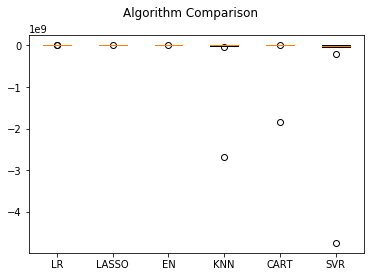

In [73]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [85]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
# pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
# pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
# pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))

In [86]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
#     print("RMSE: %.3f" % (math.sqrt(abs(cv_results.mean()))))

ScaledLR: -0.000000 (0.000000)
ScaledLASSO: -0.000000 (0.000000)
ScaledEN: -0.000000 (0.000000)


In [76]:
results

[array([-1.76991550e-20, -1.78346558e-21, -4.76548734e-22, -4.91459378e-22,
        -1.10718838e-21, -8.61251897e-22, -1.33795751e-21, -6.23579096e-22,
        -2.46384737e-22, -2.25784343e-22]),
 array([ -15347.825701  , -189235.12887074,  -73880.57488155,
         -24043.97653174,  -14866.25757397,  -12340.95647885,
         -39853.82095786,   -7863.94556402,   -5181.98778434,
          -6383.41712349]),
 array([-16733217.53135702,  -3442336.61974144,  -1152295.35352573,
          -332213.38812121,   -248278.21486488,   -187961.83823544,
          -609863.20757641,   -220717.33140251,   -279056.5239558 ,
          -620581.75701461])]

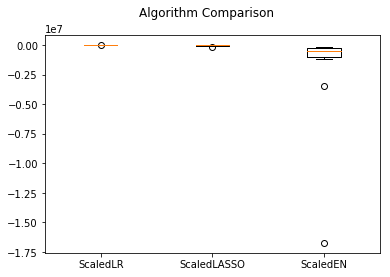

In [77]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Run Elastic Net

### Using Densities

In [204]:
# Create prdictor and response variables
train_x = test_newstate_df.iloc[:,:20]
train_y = test_newstate_df.iloc[:,-1]
train_x.head()

,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY
0,7353.0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422
1,5115.0,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140
2,5005.0,1774868,494056143933,721252426439,733561461654,5780147040071,57206,55978,113184,48359.759399,1774868,920657,854211,1234468,65662,3.27,2.59,95857,768205,451725
3,4133.0,585936,487005072197,613723856820,624450149363,6548612367402,40665,42463,83128,56491.338012,585936,316402,269534,1468305,59737,3.03,2.51,75281,803267,282862
4,3210.0,462360,315983343213,411902114464,418518490501,4125980999869,16036,16102,32138,45285.896438,462360,240313,222047,749637,61749,3.02,2.46,80493,806294,236846


In [422]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)
# Transform predictors
# from sklearn.preprocessing import PowerTransformer
# pt_data = PowerTransformer(method='box-cox')
# train_x_pt = pt_data.fit_transform(train_x)

# from scipy.stats import boxcox
# train_x_pt = boxcox(train_x)

In [423]:
# train_x_pt
train_x_std

array([[22.34795477, 18.05516815, 17.965054  , ..., 16.44519452,
        16.80905623, 18.62762542],
       [ 5.6822489 ,  9.64669999,  9.78298609, ...,  9.31051713,
         9.20807555, 11.08252361],
       [ 2.96499875,  4.82089499,  5.87652831, ...,  2.74204776,
         2.58167517,  2.70928177],
       ...,
       [-0.19646359, -0.37685625, -0.37043563, ..., -0.45093924,
        -0.44262892, -0.40747586],
       [-0.19531945, -0.36966815, -0.36346963, ..., -0.41996093,
        -0.41624254, -0.37088673],
       [-0.1937741 , -0.34420822, -0.33565532, ..., -0.3871941 ,
        -0.38137309, -0.34955075]])

#### Tune and Run

Regularization strength is regulated by alpha (similar to lambda in the equation). l1_ratio allows us to vary L1 vs L2 ratio. When the l1_ratio is set to 0 it is the same as ridge regression. When l1_ratio is set to 1 it is lasso.

In [428]:
# Tune hyperparameters for Elastic Net regression

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": [.1, .5, .7, .9, .95, .99, 1]}

eNet = ElasticNet(random_state=3, max_iter=1000)
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(train_x_std, train_y)
best_idx = grid.best_index_

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41678.51954203416, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161895.03584090917, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195211.52846741414, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210115.57965929367, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38991.51918803835, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158531.91208379835, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208113.67372772162, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209042.25466932406, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208928.88932987335, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218277.23055833086, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218825.74330476363, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203576.53017394606, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158938.75369887473, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191175.55660511294, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204883.72319995982, tolerance: 1695.9653531914894
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206293.98533976538, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46630.003611657834, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230822.3979823824, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186454.97338264264, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190694.33298899583, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190978.97933677194, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168073.2711810842, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167846.5435118922, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167389.28331844986, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226510.15314598358, tolerance: 1695.9653531914894
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222665.48881026456, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220752.91201737954, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59499.38913881907, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59579.80462290539, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56942.63155557861, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393939.6402163658, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386639.0146009138, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334992.08431829535, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5460.929937050096, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6913.898069663555, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7034.813022656832, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3085.3780808569863, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3110.7923936082516, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaco

In [429]:
print('Best Elastic Net parameters: ' + str(e_gs.best_params_))
print('Best EL cross-validation score: ' + str(e_gs.best_score_))

Best Elastic Net parameters: {'alpha': 0.1, 'l1_ratio': 1}
Best EL cross-validation score: -4144.818911275162


#### Run using parameters from tuning

In [431]:
elastic=ElasticNet(alpha=0.1,l1_ratio=1)
elastic.fit(train_x_std,train_y)

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35780.44715979218, tolerance: 1704.0840955613576
  positive)


ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### Get Variable Coefficients

In [432]:
coef = pd.Series(elastic.coef_, index = train_x.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 48 variables and eliminated the other 123 variables


In [433]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,train_x.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'AAGEBASECY': 0.0,
 'AGGDI_CY': 47.42115457157865,
 'AGGHINC_CY': 87.15589867412909,
 'AGGINC_CY': 3.412823220878211,
 'AGGNW_CY': 0.0,
 'AIFBASE_CY': 0.0,
 'AIMBASE_CY': 0.0,
 'AMERIND_CY': 0.0,
 'AREA': 0.0,
 'ASIAN_CY': 0.0,
 'ASNFBASECY': 0.0,
 'ASNMBASECY': 0.0,
 'ASSCDEG_CY': -2.2187711479879986,
 'AVGDI_CY': 0.0,
 'AVGFMSZ_CY': 1.8384091345091094,
 'AVGHHSZ_CY': 0.0,
 'AVGHINC_CY': 0.0,
 'AVGNW_CY': 1.1031864351227876,
 'AVGVAL_CY': 0.0,
 'BABYBOOMCY': -0.0,
 'BACHDEG_CY': 0.0,
 'BAGEBASECY': 0.0,
 'BLACK_CY': 0.0,
 'BLKFBASECY': 0.0,
 'BLKMBASECY': 0.0,
 'CIVLBFR_CY': -0.0,
 'EDUCBASECY': -0.0,
 'EMP_CY': -0.0,
 'FAMHH_CY': -0.0,
 'FAMPOP_CY': -0.0,
 'FEM0_CY': -13.003996879838455,
 'FEM15_CY': -0.0,
 'FEM18UP_CY': -0.0,
 'FEM20_CY': -6.4407237518483,
 'FEM21UP_CY': -0.0,
 'FEM25_CY': -0.0,
 'FEM30_CY': -0.0,
 'FEM35_CY': -0.0,
 'FEM40_CY': -0.0,
 'FEM45_CY': -0.0,
 'FEM50_CY': -0.0,
 'FEM55_CY': -0.0,
 'FEM5_CY': -0.0,
 'FEM60_CY': -0.0,
 'FEM65_CY': -0.0,
 'FEM70_CY': -0.092

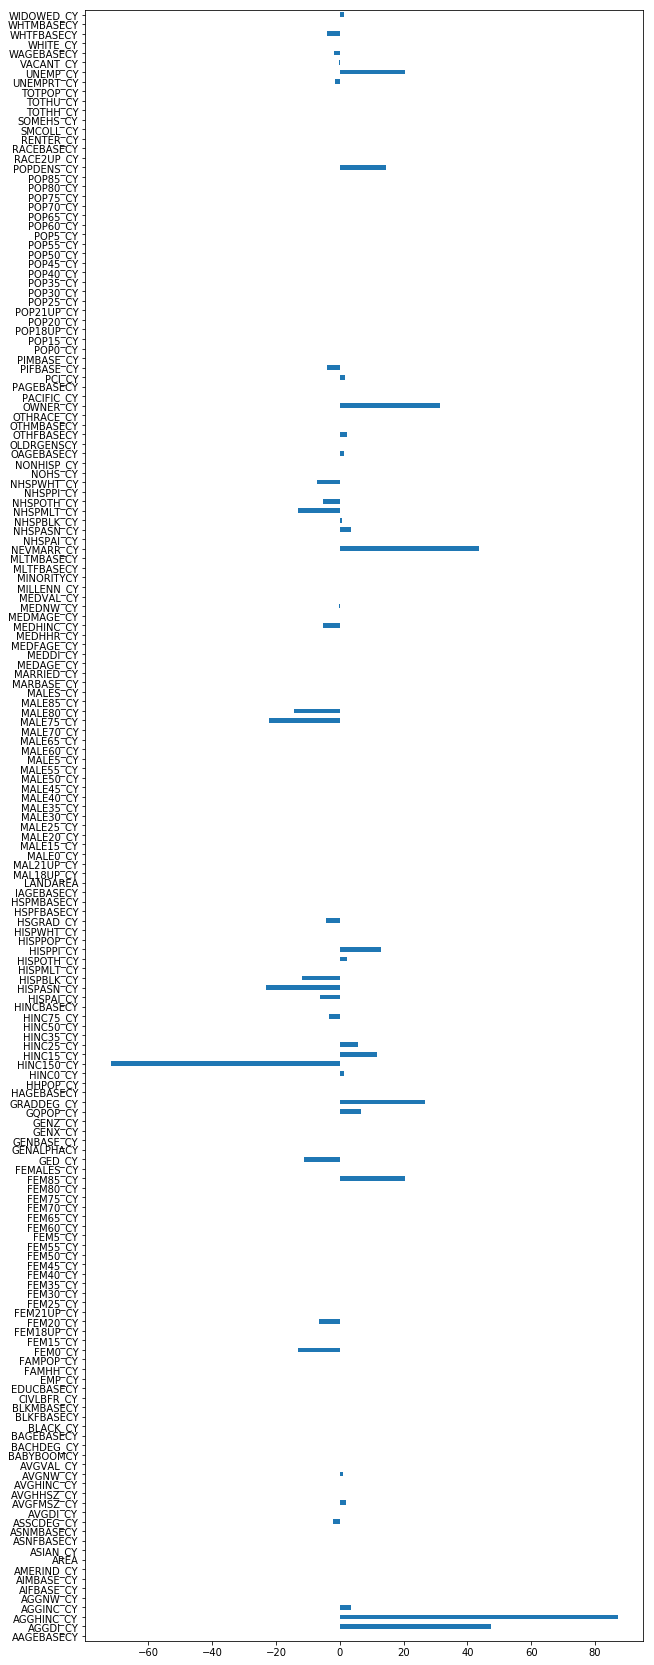

In [434]:
plt.figure(figsize=(10,30))
featureimp = pd.Series(elastic.coef_, index = train_x.columns)
featureimp.plot(kind='barh')
plt.show()

In [ ]:
# Using densities with box-cox
Best Elastic Net parameters: {'alpha': 0.1, 'l1_ratio': 0.1}
Best EL cross-validation score: -2.5487352278940628e-09

# Not using densities

### Not Using Densities

In [110]:
# Create copy of df to remove density columns
test_newstate_copy = test_newstate_df.iloc[:,:-8]
test_newstate_copy.head()

,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,7353.0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422,8055682,5552919,2345048,2345048,1186331,1158717,19595308,26629106,18678853,9166028,32063051,1246195,1267704,15535129,1399534,14709444,1533458,1442776,1332317,1220853,1252603,1262625,1290328,1247274,1173091,1008278,746364,527232,362402,447803,20024285,621048,1008060,39806791,8011720,9289070,813593,3342632,15757962,38993198,1280615,1084396,1102410,1036596,1486913,2149782,1630222,13335897,214901,94837,149373,953706,7017528,17243,15757962,7310374,4804568,7811593,7946369,374712,155779.2198,15076422,14203971,1298461,1348980,1481021,1618901,1503701,1378564,1227529,1251002,1245261,1228175,1301504,1076510,891235,637267,427533,272897,270401,19782506,32126345,15627854,36.2,56020,37.3,51.5,69051,35.1,99297,505800,10636136,25228888,1076167,1053726,11926897,159811,5713702,2195675,1176187,84542,141009,14577903,2557052,24048829,7102070,2806123,3484353,3617717,7102070,7294468,158252,158252,34254,79878,78374,2544656,2616684,30611551,2880555,28913415,3152359,2946477,2710881,2448382,2503605,2507886,2518503,2548778,2249601,1899513,1383631,954765,635299,718204,255.5,2129893,39806791,6041636,5627462,2067041,13336104,14383561,39806791,4.7,916455,1047457,21888277,21888277,10953440,10934837,1601462
1,5115.0,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140,5610338,3595450,3554094,3554094,1837649,1716445,13994294,18710254,13323060,7102474,23868426,1012163,958641,11007087,1023650,10392959,1088542,1028122,990111,912087,908014,888197,906409,1016393,815633,699159,508500,349890,230272,255883,14596063,796406,820030,28954616,5795902,7332348,603396,1902087,11500677,28351220,1099136,601595,972153,998707,1339610,1837748,1220161,10211181,108000,21467,126710,446880,3229534,4993,11500677,7563093,3900291,5712914,5787763,200692,261231.7115,10619025,9978508,1049926,1010959,1068334,1146033,1057803,1000356,900336,893942,864949,855845,1054854,749300,623922,440199,284583,169339,142828,14358553,22771838,11608584,34.8,48504,35.8,49.5,57286,33.8,89454,173734,7624216,16954978,459123,454026,7616564,92692,1406

In [170]:
# 
train_x_new = test_newstate_copy.iloc[:,1:]
# train_y_new = np.log(test_newstate_df.iloc[:,0].values+1)
train_y_new = test_newstate_df.iloc[:,0]

In [171]:
train_x_new.head()

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422,8055682,5552919,2345048,2345048,1186331,1158717,19595308,26629106,18678853,9166028,32063051,1246195,1267704,15535129,1399534,14709444,1533458,1442776,1332317,1220853,1252603,1262625,1290328,1247274,1173091,1008278,746364,527232,362402,447803,20024285,621048,1008060,39806791,8011720,9289070,813593,3342632,15757962,38993198,1280615,1084396,1102410,1036596,1486913,2149782,1630222,13335897,214901,94837,149373,953706,7017528,17243,15757962,7310374,4804568,7811593,7946369,374712,155779.2198,15076422,14203971,1298461,1348980,1481021,1618901,1503701,1378564,1227529,1251002,1245261,1228175,1301504,1076510,891235,637267,427533,272897,270401,19782506,32126345,15627854,36.2,56020,37.3,51.5,69051,35.1,99297,505800,10636136,25228888,1076167,1053726,11926897,159811,5713702,2195675,1176187,84542,141009,14577903,2557052,24048829,7102070,2806123,3484353,3617717,7102070,7294468,158252,158252,34254,79878,78374,2544656,2616684,30611551,2880555,28913415,3152359,2946477,2710881,2448382,2503605,2507886,2518503,2548778,2249601,1899513,1383631,954765,635299,718204,255.5,2129893,39806791,6041636,5627462,2067041,13336104,14383561,39806791,4.7,916455,1047457,21888277,21888277,10953440,10934837,1601462
1,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140,5610338,3595450,3554094,3554094,1837649,1716445,13994294,18710254,13323060,7102474,23868426,1012163,958641,11007087,1023650,10392959,1088542,1028122,990111,912087,908014,888197,906409,1016393,815633,699159,508500,349890,230272,255883,14596063,796406,820030,28954616,5795902,7332348,603396,1902087,11500677,28351220,1099136,601595,972153,998707,1339610,1837748,1220161,10211181,108000,21467,126710,446880,3229534,4993,11500677,7563093,3900291,5712914,5787763,200692,261231.7115,10619025,9978508,1049926,1010959,1068334,1146033,1057803,1000356,900336,893942,864949,855845,1054854,749300,623922,440199,284583,169339,142828,14358553,22771838,11608584,34.8,48504,35.8,49.5,57286,33.8,89454,173734,7624216,16954978,459123,454026,7616564,92692,1406614,3427384,466269,37515,2382

In [172]:
# # Transform predictors
# from sklearn.preprocessing import PowerTransformer
# pt_data = PowerTransformer(method='box-cox')
# train_x_pt = pt_data.fit_transform(train_x_new)

# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x_new)

In [173]:
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": [.1, .5, .7, .9, .95, .99, 1]}

eNet = ElasticNet(random_state=3, max_iter=1000)
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(train_x_std, train_y_new)

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20156.070166797137, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25580.82539699177, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36596.932696175005, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27611.69697752278, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30505.919853909458, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28290.68652379256, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26451.98568048466, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26402.902625341812, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29499.46931559191, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53351.77292431351, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50457.35871366033, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60915.047082394005, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\li

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35135.74182869109, tolerance: 10198.469210869565
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29543.79290940451, tolerance: 10062.415610869568
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7186.503147732061, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skle

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78487.06611649539, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127881.2715122926, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136975.0982249205, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41965.66307585173, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43414.320110149194, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42666.3000587859, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369594.9601081552, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342872.256096235, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371066.05115251674, tolerance: 10198.469210869565
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\lin

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172440.25613825218, tolerance: 10062.415610869568
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31015.572063338215, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68407.39152420318, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725458.5199430198, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725983.6848212457, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 669429.8122573944, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\lin

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102839.21529204986, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114155.05398217516, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123541.44240985933, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40231.34455722105, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39890.750481483876, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41666.83008177369, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\li

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=3, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [174]:
print('Best Elastic Net parameters: ' + str(grid.best_params_))
print('Best EL cross-validation score: ' + str(grid.best_score_))

Best Elastic Net parameters: {'alpha': 1, 'l1_ratio': 0.5}
Best EL cross-validation score: -35089.43647606921


#### Run using parameters from tuning

In [166]:
elastic=ElasticNet(alpha=0.0001,l1_ratio=0.1)
elastic.fit(train_x_std,train_y)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### Get Variable Coefficients

In [168]:
coef = pd.Series(elastic.coef_, index = train_x.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 6 variables and eliminated the other 173 variables


In [167]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,train_x.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'Provider_Count': 0.0,
 'AAGEBASECY': -0.0,
 'AGGDI_CY': 0.0,
 'AGGHINC_CY': 0.0,
 'AGGINC_CY': 0.0,
 'AGGNW_CY': 0.0,
 'AIFBASE_CY': -0.0,
 'AIMBASE_CY': -0.0,
 'AMERIND_CY': -0.0,
 'AREA': -0.0,
 'ASIAN_CY': -0.0,
 'ASNFBASECY': -0.0,
 'ASNMBASECY': -0.0,
 'ASSCDEG_CY': 0.0,
 'AVGDI_CY': 0.0,
 'AVGFMSZ_CY': -0.0,
 'AVGHHSZ_CY': -0.0,
 'AVGHINC_CY': 0.0,
 'AVGNW_CY': 0.0,
 'AVGVAL_CY': 1.3363209295111027e-06,
 'BABYBOOMCY': 0.0,
 'BACHDEG_CY': 0.0,
 'BAGEBASECY': 0.0,
 'BLACK_CY': 0.0,
 'BLKFBASECY': 0.0,
 'BLKMBASECY': 0.0,
 'CIVLBFR_CY': 0.0,
 'EDUCBASECY': 0.0,
 'EMP_CY': 0.0,
 'FAMHH_CY': 0.0,
 'FAMPOP_CY': 0.0,
 'FEM0_CY': -0.0,
 'FEM15_CY': 0.0,
 'FEM18UP_CY': 0.0,
 'FEM20_CY': 0.0,
 'FEM21UP_CY': 0.0,
 'FEM25_CY': 0.0,
 'FEM30_CY': 0.0,
 'FEM35_CY': 0.0,
 'FEM40_CY': 0.0,
 'FEM45_CY': 0.0,
 'FEM50_CY': 0.0,
 'FEM55_CY': 0.0,
 'FEM5_CY': 0.0,
 'FEM60_CY': 0.0,
 'FEM65_CY': 0.0,
 'FEM70_CY': 0.0,
 'FEM75_CY': 0.0,
 'FEM80_CY': 0.0,
 'FEM85_CY': 0.0,
 'FEMALES_CY': 0.0,
 'GED_CY'

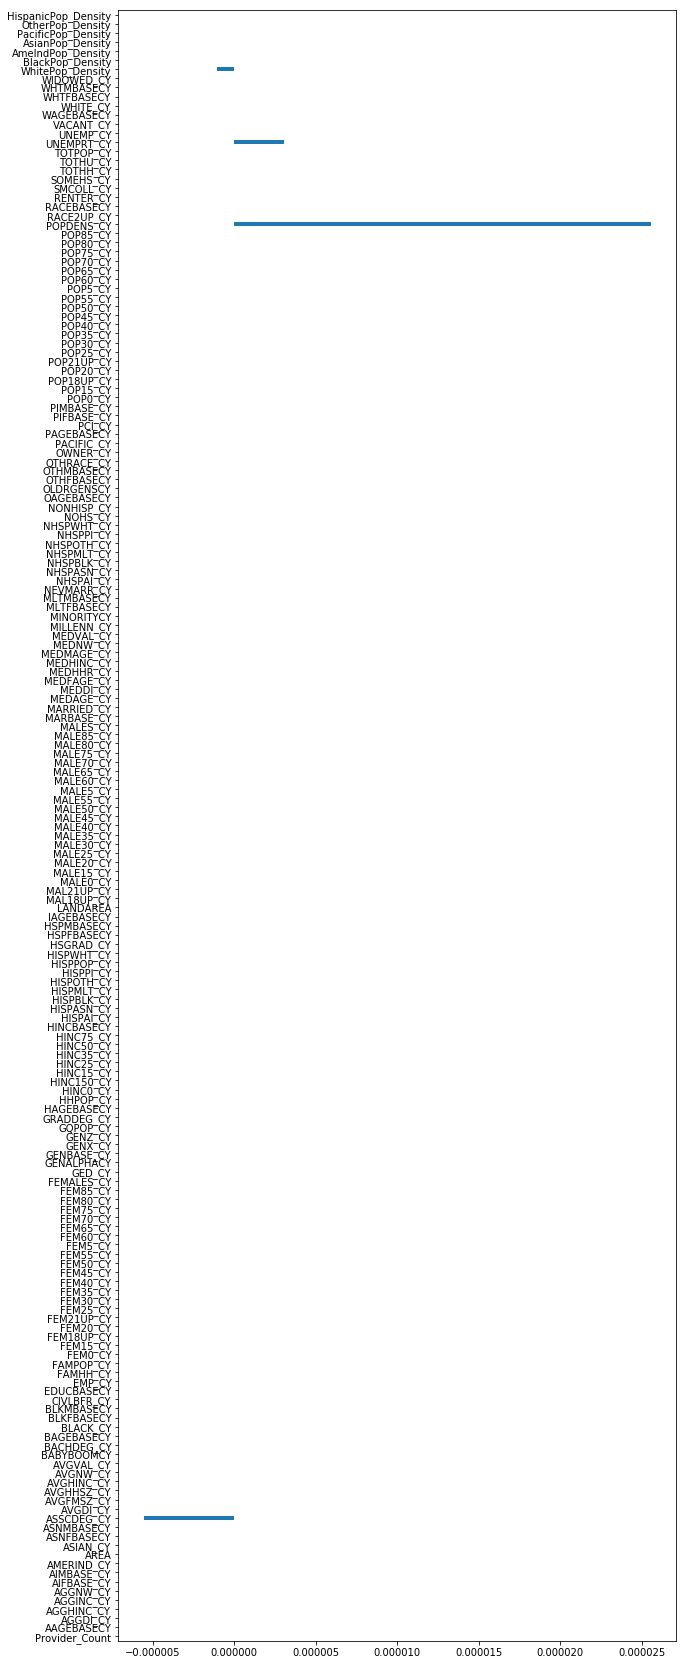

In [157]:
plt.figure(figsize=(10,30))
featureimp = pd.Series(elastic.coef_, index = train_x.columns)
featureimp.plot(kind='barh')
plt.show()